# Setup

To run this notebook on Colab, a few setup steps are required. Follow along step by step:

1. **Check your Colab region**  
   First, determine the region where your Colab instance is running. For best performance (faster data transfers), we recommend using a runtime located in the **US** or **Europe**.  
   - If your runtime is elsewhere, stop it and create a new one until it’s in one of the preferred regions.

In [ ]:
!pip install ipinfo==5.1.1 > /dev/null 2>&1
import ipinfo; info = ipinfo.getHandler().getDetails(); print(f"{info.city} ({info.country_name})")

2. **Clone the `dlfb` library**  
   Next, clone the repository that contains the `dlfb` library.

In [ ]:
%cd /content
!rm -rf ./dlfb-clone/
!git clone "https://github.com/deep-learning-for-biology/dlfb.git" dlfb-clone --branch main
%cd dlfb-clone

3. **Install dependencies**  
   Once the library is cloned, install the required dependencies.

In [ ]:
%%bash
curl -LsSf https://astral.sh/uv/install.sh | sh && \
export PATH="/root/.local/bin:${PATH}" && \
uv pip compile ./requirements/{base,dlfb,dna,gpu}.txt \
  --color never \
  --constraint ./requirements/constraints.txt | \
uv pip install -r - --system

4. **Authenticate with Google**  
   You’ll then need to authenticate with your Google account so the notebook can access and download the necessary datasets for this chapter.

In [ ]:
from google.colab import auth

auth.authenticate_user()
# NOTE: exclude models with '--no-models' flag
!dlfb-provision --chapter dna

5. **Load the `dlfb` package**  
   Finally, load the `dlfb` package.  
   - ⚠️ Note: Loading can sometimes be finicky. If you encounter issues, simply **restart the runtime**. All previously downloaded data and installed packages will persist, so you can re-run the load step without repeating everything.

In [ ]:
# Toggle JAX_DISABLE_JIT to True for easier debugging
%env JAX_DISABLE_JIT=False

try:
  import dlfb
except ImportError as exc:
  # NOTE: Packages installed in editable mode are not immediately
  #       recognized by Colab (https://stackoverflow.com/a/63312333).
  import site
  site.main()
  import dlfb

from dlfb.utils.display import display

# 3. Learning the Logic of DNA


## 3.1. Biology Primer
### 3.1.1. What Exactly Is DNA?
### 3.1.2. Coding and Noncoding Regions
### 3.1.3. How Transcription Factors Direct Gene Activity
### 3.1.4. Measuring Where Transcription Factors Bind


## 3.2. Machine Learning Primer
### 3.2.1. Convolutional Neural Networks
### 3.2.2. Convolutions for DNA Sequences
### 3.2.3. Transformers
### 3.2.4. Attention
### 3.2.5. Query, Key and Value Intuition
### 3.2.6. Multiheaded Attention
### 3.2.7. Representing Positional Information
### 3.2.8. Model Interpretation
### 3.2.9. In Silico Saturation Mutagenesis
### 3.2.10. Input Gradients


In [2]:
import flax.linen as nn
import numpy as np

## 3.3. Building a Simple Prototype
### 3.3.1. Building a Dataset
#### 3.3.1.1. Loading the Labeled Sequences


In [3]:
import pandas as pd

from dlfb.utils.context import assets

train_df = pd.read_csv(assets("dna/datasets/CTCF_train_sequences.csv"))
print(train_df)

                  sequence  label transcription_factor subset
0      TACCACATGAGTTCTC...      1                 CTCF  train
1      CATCAACACTCGTGCG...      0                 CTCF  train
2      GCACACAGCGCAGGAA...      1                 CTCF  train
...                    ...    ...                  ...    ...
61080  CCTCCCTCCCATCCCC...      1                 CTCF  train
61081  CAGGAATGCACCGGAA...      0                 CTCF  train
61082  AAAACAGAAACTGAAA...      0                 CTCF  train

[61083 rows x 4 columns]


In [4]:
train_df["label"].value_counts()

label
1    30545
0    30538
Name: count, dtype: int64

In [5]:
from dlfb.dna.utils import dna_to_one_hot

display(["import numpy as np", dna_to_one_hot])

import numpy as np

def dna_to_one_hot(dna_sequence: str) -> np.ndarray:
  """Convert DNA into a one-hot encoded format with channel ordering ACGT."""
  base_to_one_hot = {
    "A": (1, 0, 0, 0),
    "C": (0, 1, 0, 0),
    "G": (0, 0, 1, 0),
    "T": (0, 0, 0, 1),
    "N": (1, 1, 1, 1),  # N represents any unknown or ambiguous base.
  }
  one_hot_encoded = np.array([base_to_one_hot[base] for base in dna_sequence])
  return one_hot_encoded

In [6]:
dna_to_one_hot("AAACGT")

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

In [7]:
x_train = np.array([dna_to_one_hot(seq) for seq in train_df["sequence"]])
y_train = train_df["label"].values[:, None]

In [8]:
from dlfb.dna.dataset import load_dataset

display([load_dataset])

def load_dataset(sequence_db) -> dict[str, np.ndarray]:
  """Load sequences and labels from a CSV into numpy arrays."""
  df = pd.read_csv(sequence_db)
  return {
    "labels": df["label"].to_numpy()[:, None],
    "sequences": np.array([dna_to_one_hot(seq) for seq in df["sequence"]]),
  }

#### 3.3.1.2. Convert the Data to a TensorFlow Dataset


In [9]:
from dlfb.dna.dataset import convert_to_tfds

display([convert_to_tfds])

def convert_to_tfds(
  dataset, batch_size: int | None = None, is_training: bool = False
):
  """Convert DNA sequences and labels to a TensorFlow dataset."""
  ds = tf.data.Dataset.from_tensor_slices(dataset)
  if is_training:
    ds = ds.shuffle(buffer_size=len(dataset["sequences"]))
    ds = ds.repeat()
  batch_size = batch_size or len(dataset["labels"])
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds

In [10]:
batch_size = 32

train_ds = convert_to_tfds(
  load_dataset(assets("dna/datasets/CTCF_train_sequences.csv")),
  batch_size=batch_size,
  is_training=True,
)

In [11]:
batch = next(train_ds.as_numpy_iterator())
print(f'Batch sequence shape: {batch["sequences"].shape}')
print(f'Batch sequence instances: {batch["sequences"][:3,:3,]}...')
print(f'Batch labels shape: {batch["labels"].shape}')
print(f'Batch labels instances: {batch["labels"][:3,]}...')

Batch sequence shape: (32, 200, 4)
Batch sequence instances: [[[0 1 0 0]
  [0 1 0 0]
  [0 0 0 1]]

 [[0 0 1 0]
  [0 0 0 1]
  [0 0 0 1]]

 [[0 0 1 0]
  [0 0 0 1]
  [0 1 0 0]]]...
Batch labels shape: (32, 1)
Batch labels instances: [[1]
 [0]
 [0]]...


In [12]:
valid_ds = load_dataset(assets("dna/datasets/CTCF_valid_sequences.csv"))

### 3.3.2. Defining a Simple Convolutional Model


In [13]:
from dlfb.dna.model import ConvModel

display([ConvModel], hide=[ConvModel.create_train_state])

class ConvModel(nn.Module):
  """Basic CNN model for binary sequence classification."""

  conv_filters: int = 64  # Number of filters for conv layers.
  kernel_size: tuple[int] = (10,)  # Kernel size for 1D conv layers.
  dense_units: int = 128  # Units in first dense fully-connected layer.

  @nn.compact
  def __call__(self, x):
    # First convolutional layer.
    x = nn.Conv(
      features=self.conv_filters, kernel_size=self.kernel_size, padding="SAME"
    )(x)
    x = nn.gelu(x)
    x = nn.max_pool(x, window_shape=(2,), strides=(2,))

    # Second convolutional layer.
    x = nn.Conv(
      features=self.conv_filters, kernel_size=self.kernel_size, padding="SAME"
    )(x)
    x = nn.gelu(x)
    x = nn.max_pool(x, window_shape=(2,), strides=(2,))

    # Flatten the values before passing them to the dense layers.
    x = x.reshape((x.shape[0], -1))

    # First dense layer.
    x = nn.Dense(self.dense_units)(x)
    x = nn.gelu(x)

    # Second dense layer.
    x = nn.Dense(self.dense_units // 2)(x)
    x = nn.gelu(x)

    # Output layer (single unit for binary classification).
    return nn.Dense(1)(x)

In [14]:
model = ConvModel()

In [15]:
import jax
import jax.numpy as jnp

dummy_input = jnp.ones((1, *batch["sequences"][1,].shape))
print(dummy_input.shape)

rng_init = jax.random.PRNGKey(42)
variables = model.init(rng_init, dummy_input)
params = variables["params"]

(1, 200, 4)


#### 3.3.2.1. Examining Model Tensor Shapes


In [16]:
params.keys()

dict_keys(['Conv_0', 'Conv_1', 'Dense_0', 'Dense_1', 'Dense_2'])

In [17]:
for layer_name in params.keys():
  print(f'Layer {layer_name} param shape: {params[layer_name]["kernel"].shape}')

Layer Conv_0 param shape: (10, 4, 64)
Layer Conv_1 param shape: (10, 64, 64)
Layer Dense_0 param shape: (3200, 128)
Layer Dense_1 param shape: (128, 64)
Layer Dense_2 param shape: (64, 1)


#### 3.3.2.2. Making Predictions with the Model


In [18]:
logits = model.apply({"params": params}, batch["sequences"])

# Apply sigmoid to convert logits to probabilities.
probs = nn.sigmoid(logits)

# Print just the first few predictions.
print(probs[0:5])

[[0.4926631 ]
 [0.49351025]
 [0.48930115]
 [0.4889785 ]
 [0.4955037 ]]


#### 3.3.2.3. Defining a Loss Function


In [19]:
import optax


def calculate_loss(params, batch):
  """Make predictions on batch and compute binary cross entropy loss."""
  logits = model.apply({"params": params}, batch["sequences"])
  loss = optax.sigmoid_binary_cross_entropy(logits, batch["labels"]).mean()
  return loss

In [20]:
calculate_loss(params, batch)

Array(0.6892605, dtype=float32)

#### 3.3.2.4. Defining the `TrainState`


In [21]:
learning_rate = 0.001

tx = optax.adam(learning_rate)

In [22]:
from flax.training.train_state import TrainState

state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)

In [23]:
def create_train_state(model, rng, dummy_input, tx) -> TrainState:
  variables = model.init(rng, dummy_input)
  state = TrainState.create(
    apply_fn=model.apply, params=variables["params"], tx=tx
  )
  return state

#### 3.3.2.5. Defining a Single Training Step


In [24]:
@jax.jit
def train_step(state, batch):
  """Run single training step to compute gradients and update model params."""
  grad_fn = jax.value_and_grad(calculate_loss, has_aux=False)
  loss, grads = grad_fn(state.params, batch)
  state = state.apply_gradients(grads=grads)
  return state, loss

In [25]:
state, loss = train_step(state, batch)

In [26]:
calculate_loss(state.params, batch)

Array(0.60415536, dtype=float32)

#### 3.3.2.6. Training the Simple Model


In [27]:
import tqdm

# Reinitialize the model state to ensure we start fresh each time cell is run.
rng_init = jax.random.PRNGKey(42)
state = create_train_state(model, rng_init, dummy_input, tx)

# Keep track of both the training and validation set losses.
train_losses, valid_losses = [], []
train_batches = train_ds.as_numpy_iterator()

# We use tqdm, which is a progress bar.
for step in tqdm.tqdm(range(500)):
  batch = next(train_batches)
  state, loss = train_step(state, batch)
  train_losses.append({"step": step, "loss": loss.item()})

  # Compute loss on the entire validation set occasionally (every 100 steps).
  if step % 100 == 0:
    valid_loss = calculate_loss(state.params, valid_ds)
    valid_losses.append({"step": step, "loss": valid_loss.item()})

losses = pd.concat(
  [
    pd.DataFrame(train_losses).assign(split="train"),
    pd.DataFrame(valid_losses).assign(split="valid"),
  ]
)


  0%|                                                                                                            | 0/500 [00:00<?, ?it/s]


  0%|▏                                                                                                   | 1/500 [00:00<06:10,  1.35it/s]


  2%|█▉                                                                                                 | 10/500 [00:00<00:31, 15.39it/s]


  4%|███▊                                                                                               | 19/500 [00:00<00:16, 28.75it/s]


  6%|█████▌                                                                                             | 28/500 [00:01<00:11, 40.76it/s]


  7%|███████▎                                                                                           | 37/500 [00:01<00:09, 51.02it/s]


  9%|█████████                                                                                          | 46/500 [00:01<00:07, 59.08it/s]


 11%|██████████▉                                                                                        | 55/500 [00:01<00:06, 65.42it/s]


 13%|████████████▋                                                                                      | 64/500 [00:01<00:06, 70.26it/s]


 15%|██████████████▍                                                                                    | 73/500 [00:01<00:05, 74.04it/s]


 16%|████████████████▏                                                                                  | 82/500 [00:01<00:05, 77.11it/s]


 18%|██████████████████                                                                                 | 91/500 [00:01<00:05, 78.69it/s]


 20%|███████████████████▌                                                                              | 100/500 [00:01<00:04, 80.89it/s]


 22%|█████████████████████▎                                                                            | 109/500 [00:02<00:08, 47.88it/s]


 24%|███████████████████████▏                                                                          | 118/500 [00:02<00:06, 54.97it/s]


 25%|████████████████████████▉                                                                         | 127/500 [00:02<00:06, 61.47it/s]


 27%|██████████████████████████▋                                                                       | 136/500 [00:02<00:05, 66.80it/s]


 29%|████████████████████████████▍                                                                     | 145/500 [00:02<00:04, 71.21it/s]


 31%|██████████████████████████████▏                                                                   | 154/500 [00:02<00:04, 74.60it/s]


 33%|███████████████████████████████▉                                                                  | 163/500 [00:02<00:04, 77.34it/s]


 34%|█████████████████████████████████▋                                                                | 172/500 [00:03<00:04, 79.32it/s]


 36%|███████████████████████████████████▍                                                              | 181/500 [00:03<00:03, 80.89it/s]


 38%|█████████████████████████████████████▏                                                            | 190/500 [00:03<00:03, 81.35it/s]


 40%|███████████████████████████████████████                                                           | 199/500 [00:03<00:03, 81.17it/s]


 42%|████████████████████████████████████████▊                                                         | 208/500 [00:03<00:05, 49.23it/s]


 43%|██████████████████████████████████████████▌                                                       | 217/500 [00:03<00:05, 56.20it/s]


 45%|████████████████████████████████████████████▎                                                     | 226/500 [00:03<00:04, 62.58it/s]


 47%|██████████████████████████████████████████████                                                    | 235/500 [00:04<00:03, 67.98it/s]


 49%|███████████████████████████████████████████████▊                                                  | 244/500 [00:04<00:03, 72.08it/s]


 51%|█████████████████████████████████████████████████▌                                                | 253/500 [00:04<00:03, 74.95it/s]


 52%|███████████████████████████████████████████████████▎                                              | 262/500 [00:04<00:03, 77.28it/s]


 54%|█████████████████████████████████████████████████████                                             | 271/500 [00:04<00:02, 79.08it/s]


 56%|██████████████████████████████████████████████████████▉                                           | 280/500 [00:04<00:02, 80.31it/s]


 58%|████████████████████████████████████████████████████████▋                                         | 289/500 [00:04<00:02, 81.54it/s]


 60%|██████████████████████████████████████████████████████████▍                                       | 298/500 [00:04<00:02, 82.16it/s]


 61%|████████████████████████████████████████████████████████████▏                                     | 307/500 [00:05<00:03, 48.72it/s]


 63%|█████████████████████████████████████████████████████████████▉                                    | 316/500 [00:05<00:03, 55.31it/s]


 65%|███████████████████████████████████████████████████████████████▌                                  | 324/500 [00:05<00:02, 60.41it/s]


 66%|█████████████████████████████████████████████████████████████████                                 | 332/500 [00:05<00:02, 64.73it/s]


 68%|██████████████████████████████████████████████████████████████████▊                               | 341/500 [00:05<00:02, 69.24it/s]


 70%|████████████████████████████████████████████████████████████████████▌                             | 350/500 [00:05<00:02, 72.60it/s]


 72%|██████████████████████████████████████████████████████████████████████▎                           | 359/500 [00:05<00:01, 75.35it/s]


 74%|████████████████████████████████████████████████████████████████████████▏                         | 368/500 [00:05<00:01, 77.39it/s]


 75%|█████████████████████████████████████████████████████████████████████████▉                        | 377/500 [00:06<00:01, 79.05it/s]


 77%|███████████████████████████████████████████████████████████████████████████▋                      | 386/500 [00:06<00:01, 80.76it/s]


 79%|█████████████████████████████████████████████████████████████████████████████▍                    | 395/500 [00:06<00:01, 81.36it/s]


 81%|███████████████████████████████████████████████████████████████████████████████▏                  | 404/500 [00:06<00:01, 48.96it/s]


 83%|████████████████████████████████████████████████████████████████████████████████▉                 | 413/500 [00:06<00:01, 55.74it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████▋               | 422/500 [00:06<00:01, 62.05it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████▍             | 431/500 [00:06<00:01, 67.33it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████▏           | 440/500 [00:07<00:00, 71.58it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████          | 449/500 [00:07<00:00, 74.75it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████▊        | 458/500 [00:07<00:00, 77.04it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████▌      | 467/500 [00:07<00:00, 78.98it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████▎    | 476/500 [00:07<00:00, 80.38it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████   | 485/500 [00:07<00:00, 81.32it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████▊ | 494/500 [00:07<00:00, 81.43it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 64.66it/s]

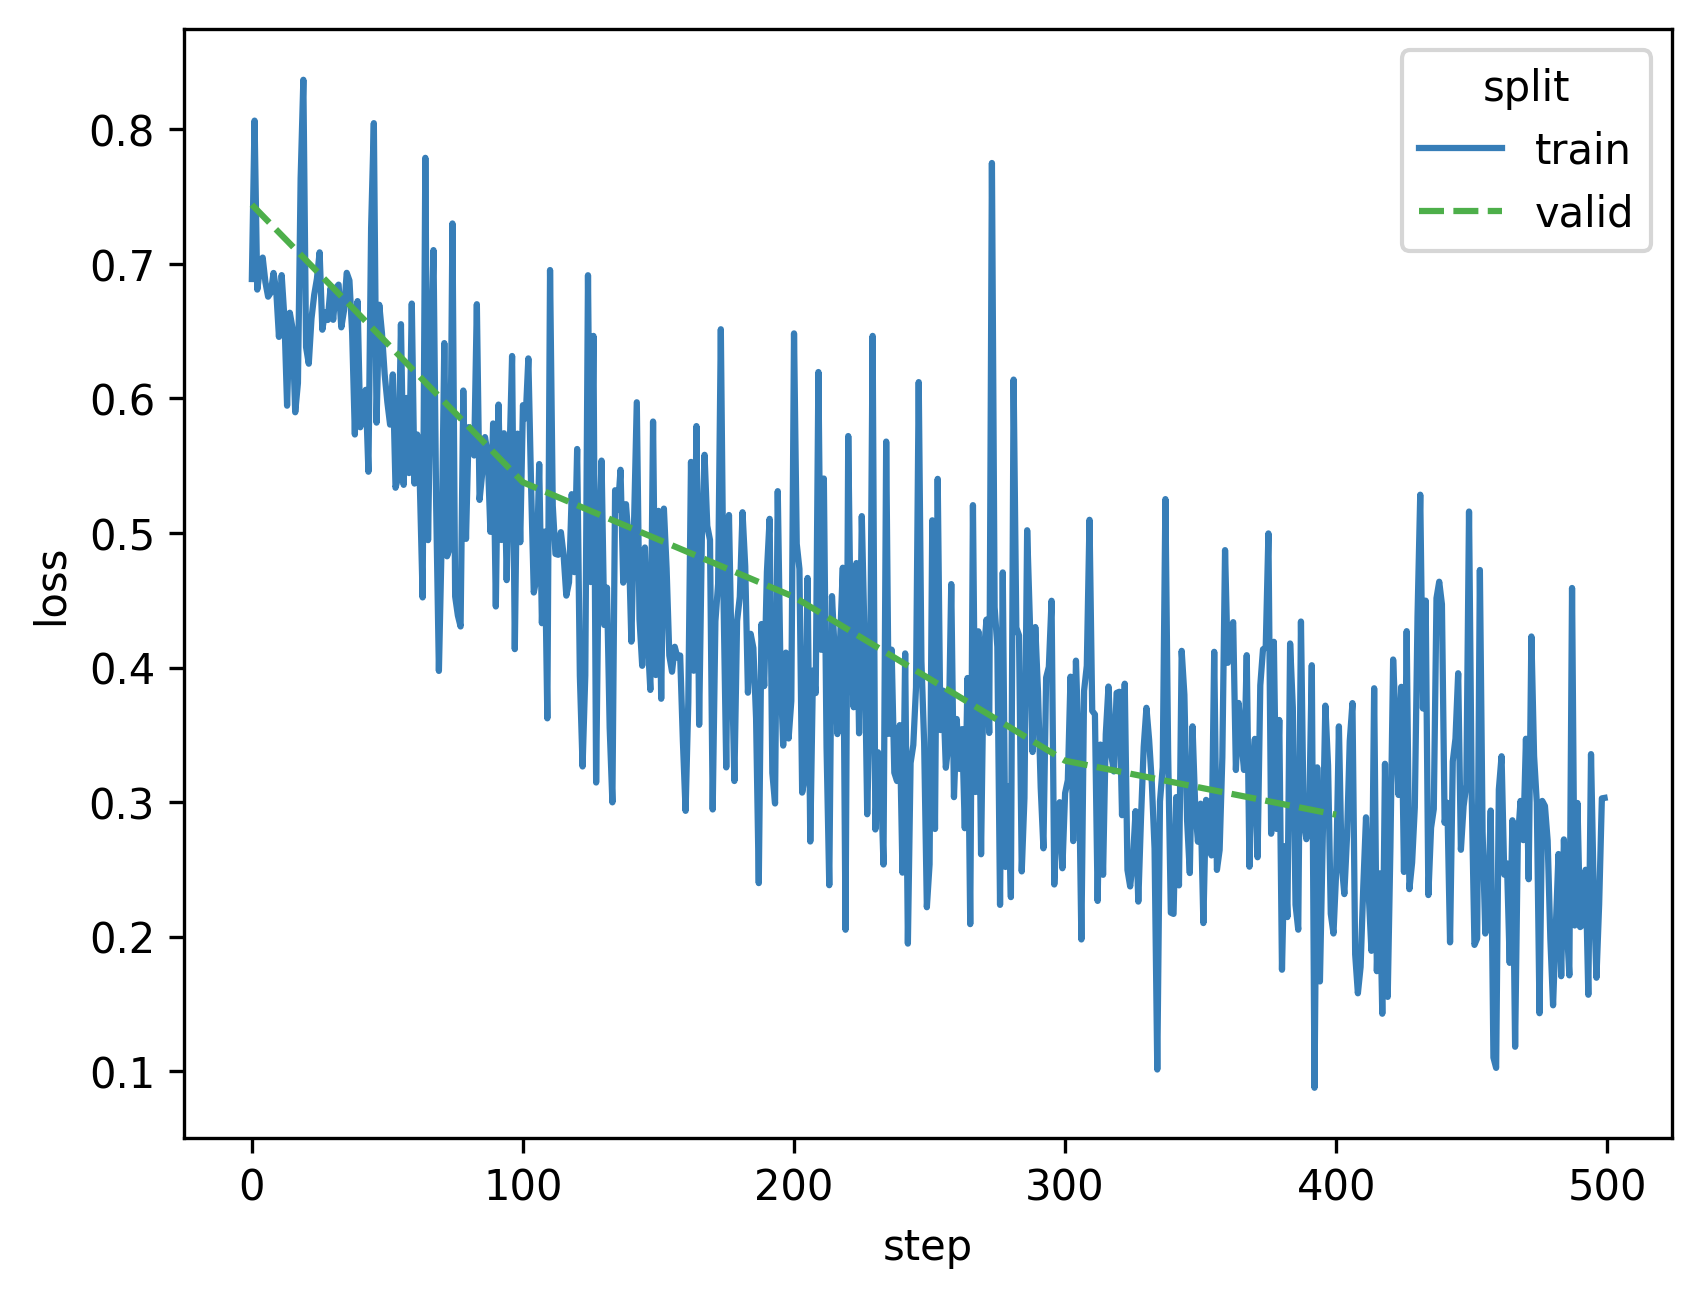

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

from dlfb.utils.metric_plots import DEFAULT_SPLIT_COLORS

sns.lineplot(
  data=losses,
  x="step",
  y="loss",
  hue="split",
  style="split",
  palette=DEFAULT_SPLIT_COLORS
);

#### 3.3.2.7. Sanity Checking the Model


In [29]:
ctcf_motif_dna = "CCACCAGGGGGCGC" * 14 + "AAAA"
print("Length of CTCF motif-filled DNA string:", len(ctcf_motif_dna))

# We add the None here as a batch axis, since our model expects batched input.
ctcf_input = dna_to_one_hot(ctcf_motif_dna)[None, :]
ctcf_input.shape

Length of CTCF motif-filled DNA string: 200


(1, 200, 4)

In [30]:
jax.nn.sigmoid(model.apply({"params": state.params}, ctcf_input))

Array([[0.99997437]], dtype=float32)

In [31]:
random_dna_strings = [
  "A" * 200,
  "C" * 200,
  "G" * 200,
  "T" * 200,
  "ACGTACGT" * 25,
  "TCGATCGT" * 25,
  "TATACGCG" * 25,
  "CAGGCAGG" * 25,
]

probabilities = []

for random_dna_string in random_dna_strings:
  random_dna_input = dna_to_one_hot(random_dna_string)[None, :]

  probabilities.append(
    jax.nn.sigmoid(model.apply({"params": state.params}, random_dna_input))[0]
  )

probabilities

[Array([0.19517948], dtype=float32),
 Array([0.00170899], dtype=float32),
 Array([0.00988429], dtype=float32),
 Array([0.00625254], dtype=float32),
 Array([0.12562892], dtype=float32),
 Array([0.04102018], dtype=float32),
 Array([0.04193167], dtype=float32),
 Array([0.00932908], dtype=float32)]

In [32]:
from dlfb.utils.restore import store

store(assets("dna/models/prototype"), state, metrics=losses.to_dict("records"))

## 3.4. Increasing Complexity
### 3.4.1. *In Silico* Mutagenesis


In [3]:
# The first positive example of a sequence that binds the transcription factor.
first_positive_index = np.argmax(valid_ds["labels"].flatten() == 1)

original_sequence = valid_ds["sequences"][first_positive_index].copy()
print(f'This sequence has label: {valid_ds["labels"][4]}')

This sequence has label: [1]


In [4]:
pred = nn.sigmoid(
  model.apply({"params": state.params}, original_sequence[None, :])
)
pred

Array([[0.9581409]], dtype=float32)

In [6]:
sequence = original_sequence.copy()
print(f"Original base at index 100: {sequence[100]}")

sequence[100] = np.array([0, 1, 0, 0])
print(f"Mutated base at index 100: {sequence[100]}")

Original base at index 100: [0 0 1 0]
Mutated base at index 100: [0 1 0 0]


In [7]:
pred_with_mutation = nn.sigmoid(
  model.apply({"params": state.params}, sequence[None, :])
)
pred_with_mutation

Array([[0.93434644]], dtype=float32)

#### 3.4.1.1. Implementing *In Silico* Saturation Mutagenesis


In [9]:
def generate_all_mutations(sequence: np.ndarray) -> np.ndarray:
  """Generate all possible single base mutations of a one-hot DNA sequence."""
  mutated_sequences = []
  for i in range(sequence.shape[0]):
    # At each position, one the four 'mutations' is the original base (no-op).
    for j in range(4):
      mutated_sequence = sequence.copy()
      mutated_sequence[i] = np.zeros(4)
      mutated_sequence[i][j] = 1
      mutated_sequences.append(mutated_sequence)

  sequences = np.stack(mutated_sequences)
  return sequences


mutated_sequences = generate_all_mutations(sequence=original_sequence.copy())
print(f"Shape of mutated sequences: {mutated_sequences.shape}")

Shape of mutated sequences: (800, 200, 4)


In [10]:
preds = nn.sigmoid(model.apply({"params": state.params}, mutated_sequences))

# Reshape to get the shape (sequence_length, dna_bases).
preds = preds.reshape((200, 4))

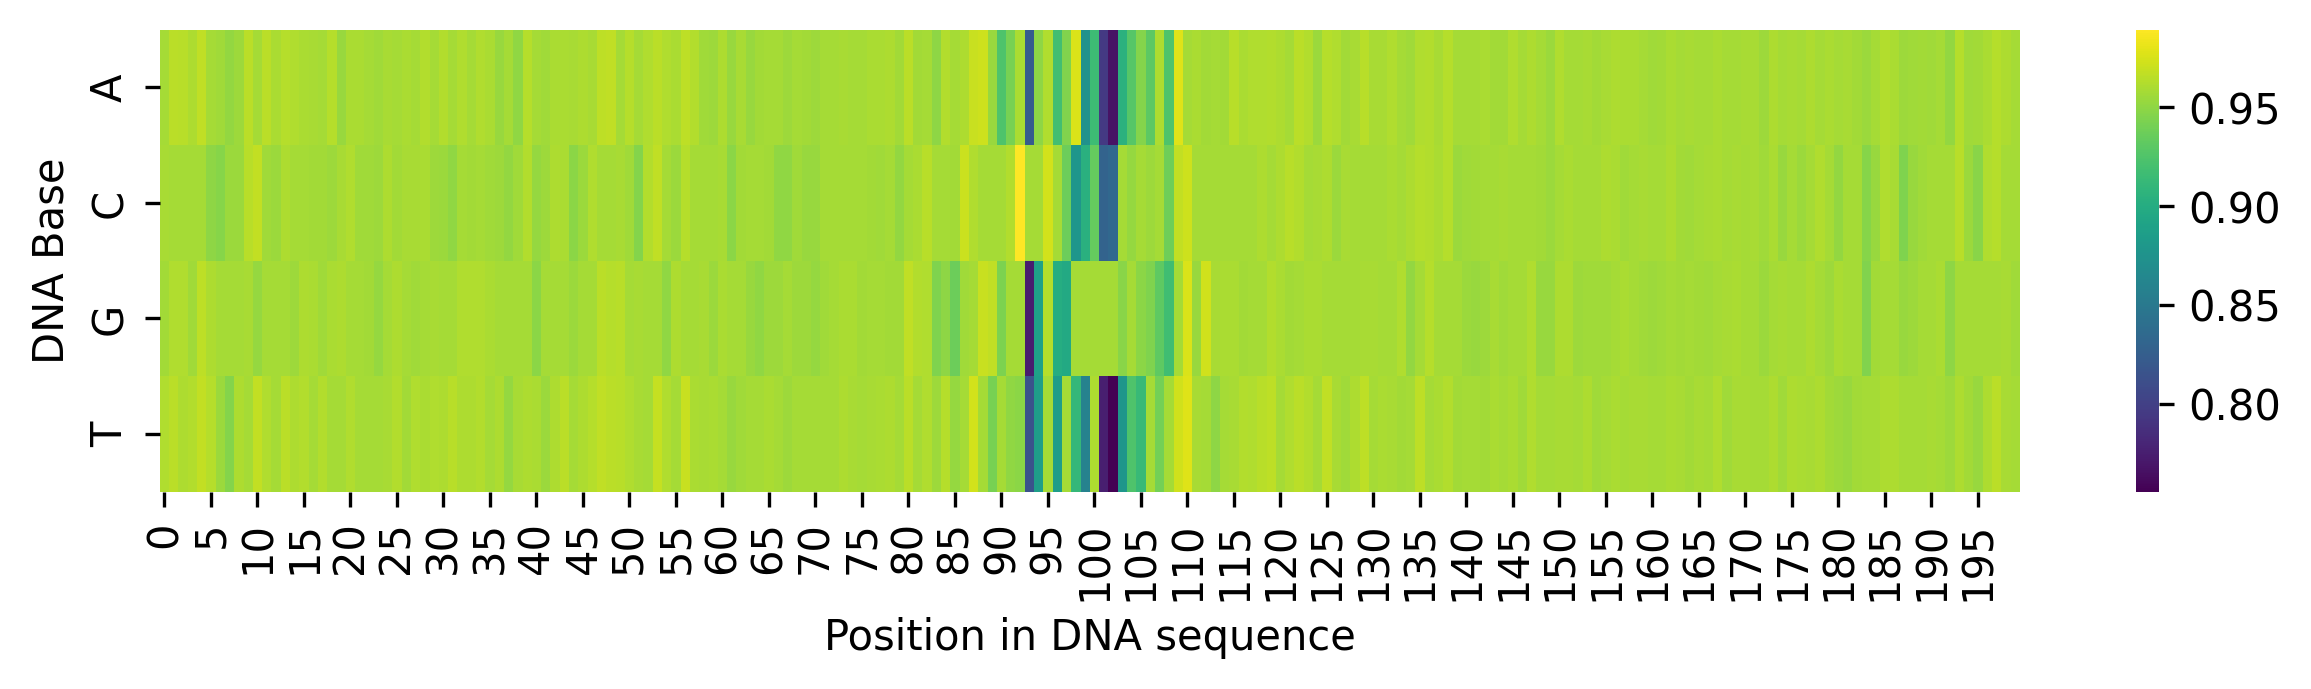

In [11]:
plt.figure(figsize=(10, 2))
sns.heatmap(preds.T, cmap="viridis", yticklabels=["A", "C", "G", "T"])
plt.xlabel("Position in DNA sequence")
plt.ylabel("DNA Base");

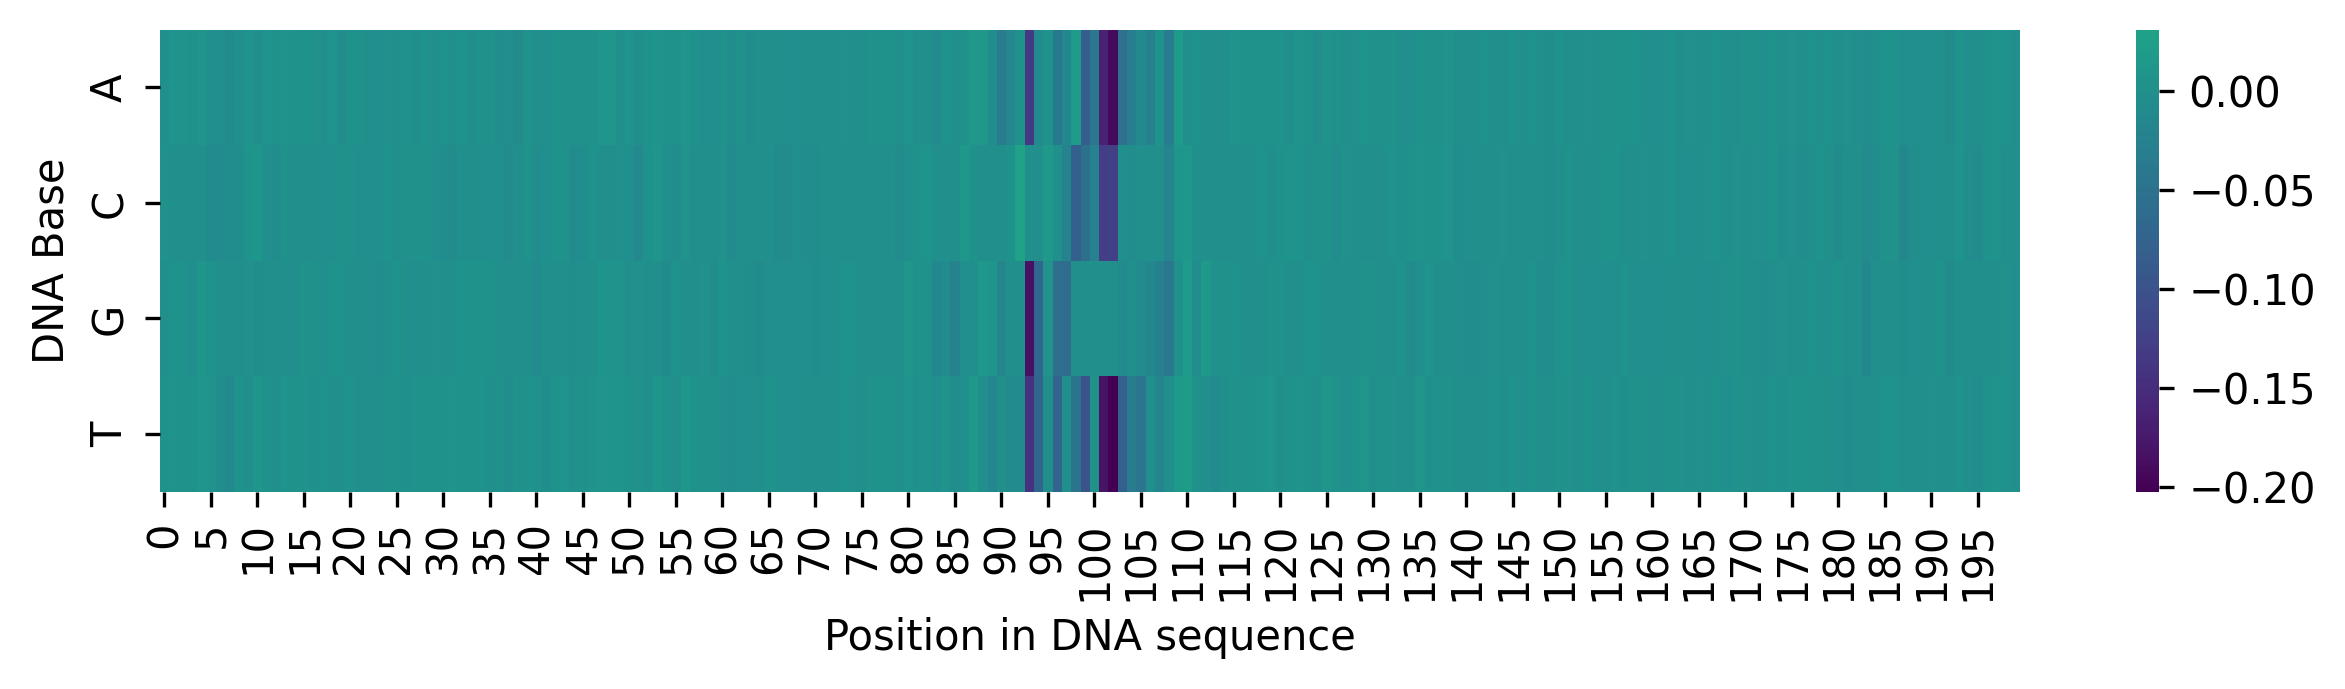

In [12]:
baseline_pred = nn.sigmoid(
  model.apply({"params": state.params}, original_sequence[None, :])
)
deltas = preds - baseline_pred

plt.figure(figsize=(10, 2))
sns.heatmap(deltas.T, center=0, cmap="viridis", yticklabels=["A", "C", "G", "T"])
plt.xlabel("Position in DNA sequence")
plt.ylabel("DNA Base");

In [13]:
from dlfb.dna.inspect import describe_change

display([describe_change])

def describe_change(
  idx, deltas: np.ndarray, sequence: np.ndarray, bases=["A", "C", "G", "T"]
) -> str:
  """Describe the effect of mutating one base to another."""
  seq_pos, base_idx = idx
  original_base = bases[np.argmax(sequence[seq_pos])]
  new_base = bases[base_idx]
  perc_delta = deltas[idx].item() * 100
  direction = "increase" if perc_delta >= 0 else "decrease"
  mutation = f"{original_base}→{new_base}"
  change = f"position {seq_pos} with {mutation} ({perc_delta:.2f}% {direction})"
  return change

In [14]:
for i in range(4):
  print(describe_change((100, i), deltas, original_sequence))

position 100 with G→A (-4.20% decrease)
position 100 with G→C (-2.38% decrease)
position 100 with G→G (0.00% increase)
position 100 with G→T (0.24% increase)


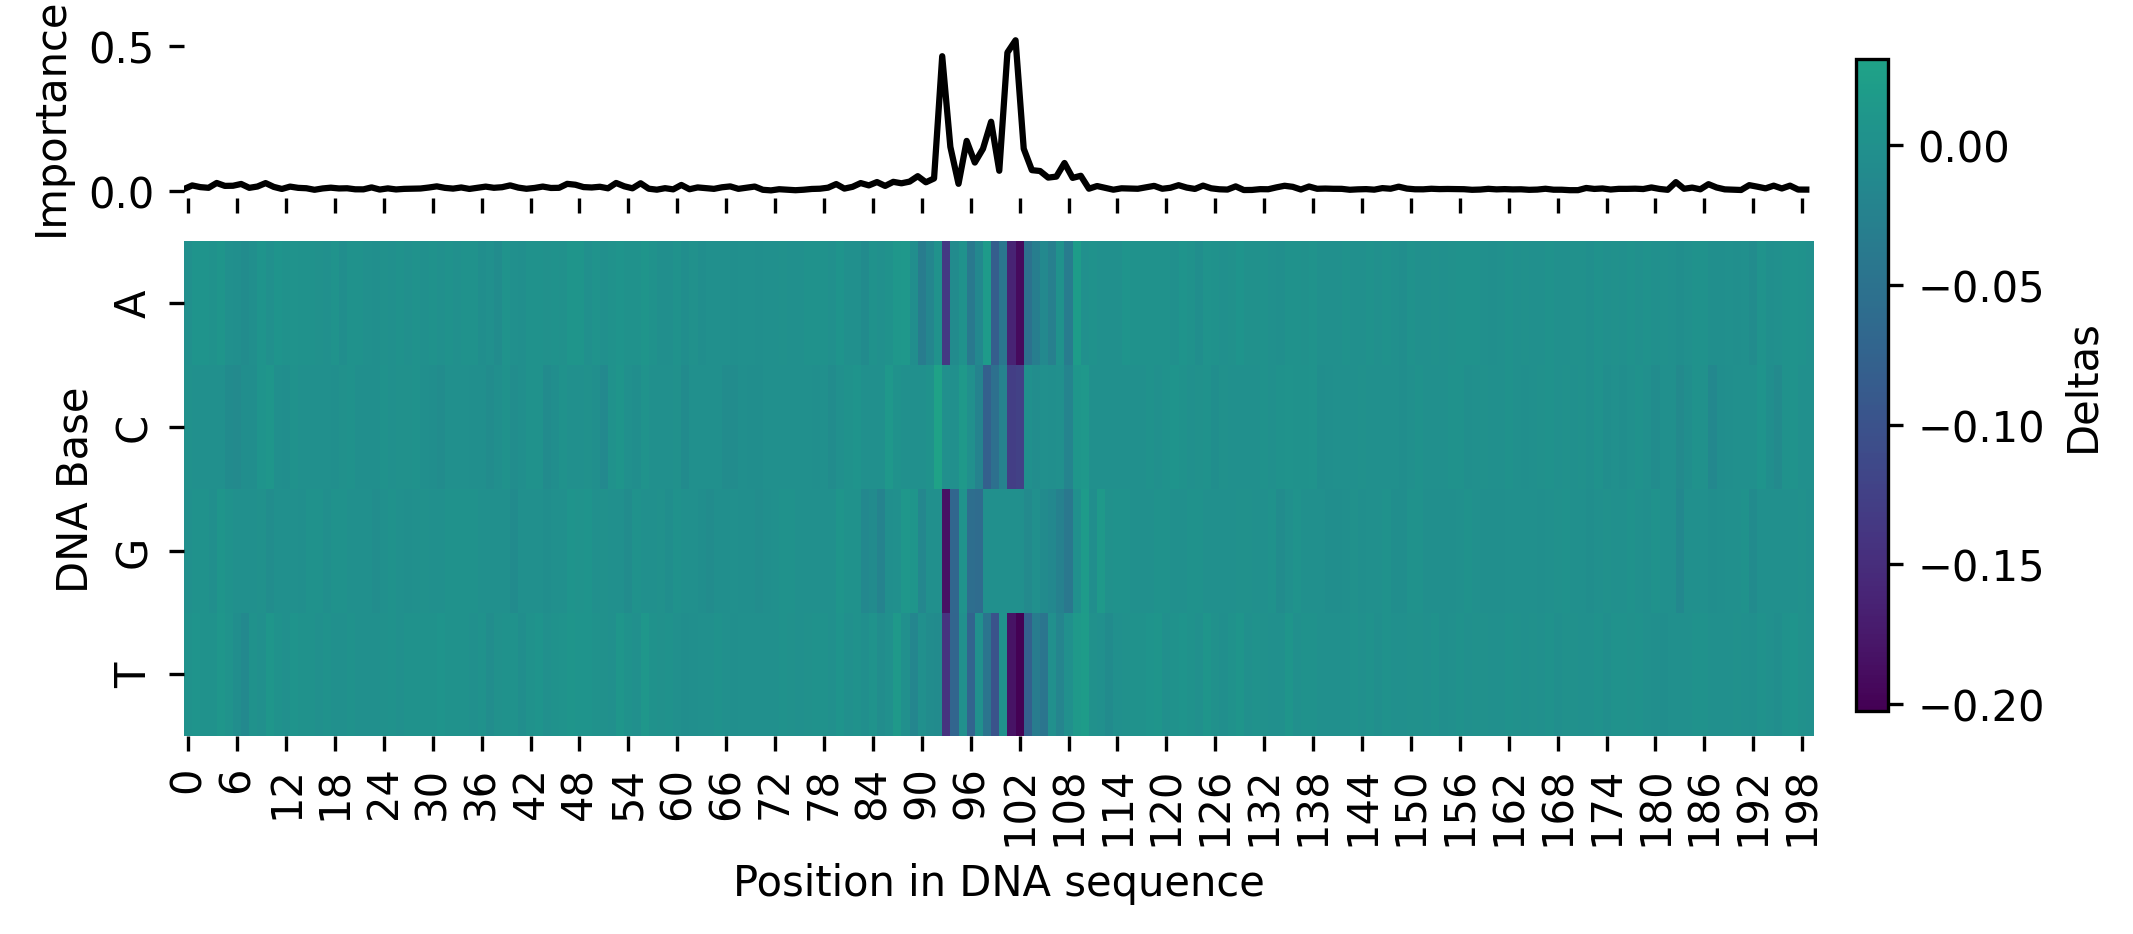

In [15]:
from dlfb.dna.inspect import plot_binding_site

importance = np.sum(np.abs(deltas), axis=1)
plot_binding_site(
  panels={
    "tiles": {"label": "Deltas", "values": deltas},
    "line": {"label": "Importance", "values": importance},
  }
);

#### 3.4.1.2. Verifying Motif Presence


In [17]:
from dlfb.dna.utils import one_hot_to_dna

display([one_hot_to_dna])

def one_hot_to_dna(one_hot_encoded: np.ndarray) -> str:
  """Convert one-hot encoded array back to DNA sequence."""
  one_hot_to_base = {
    (1, 0, 0, 0): "A",
    (0, 1, 0, 0): "C",
    (0, 0, 1, 0): "G",
    (0, 0, 0, 1): "T",
    (1, 1, 1, 1): "N",  # N represents any unknown or ambiguous base.
  }

  dna_sequence = "".join(
    one_hot_to_base[tuple(base)] for base in one_hot_encoded
  )
  return dna_sequence

In [18]:
print(one_hot_to_dna(original_sequence)[0:25], "...")

ACCCCAGGGTAGGGCCTATTGTATG ...


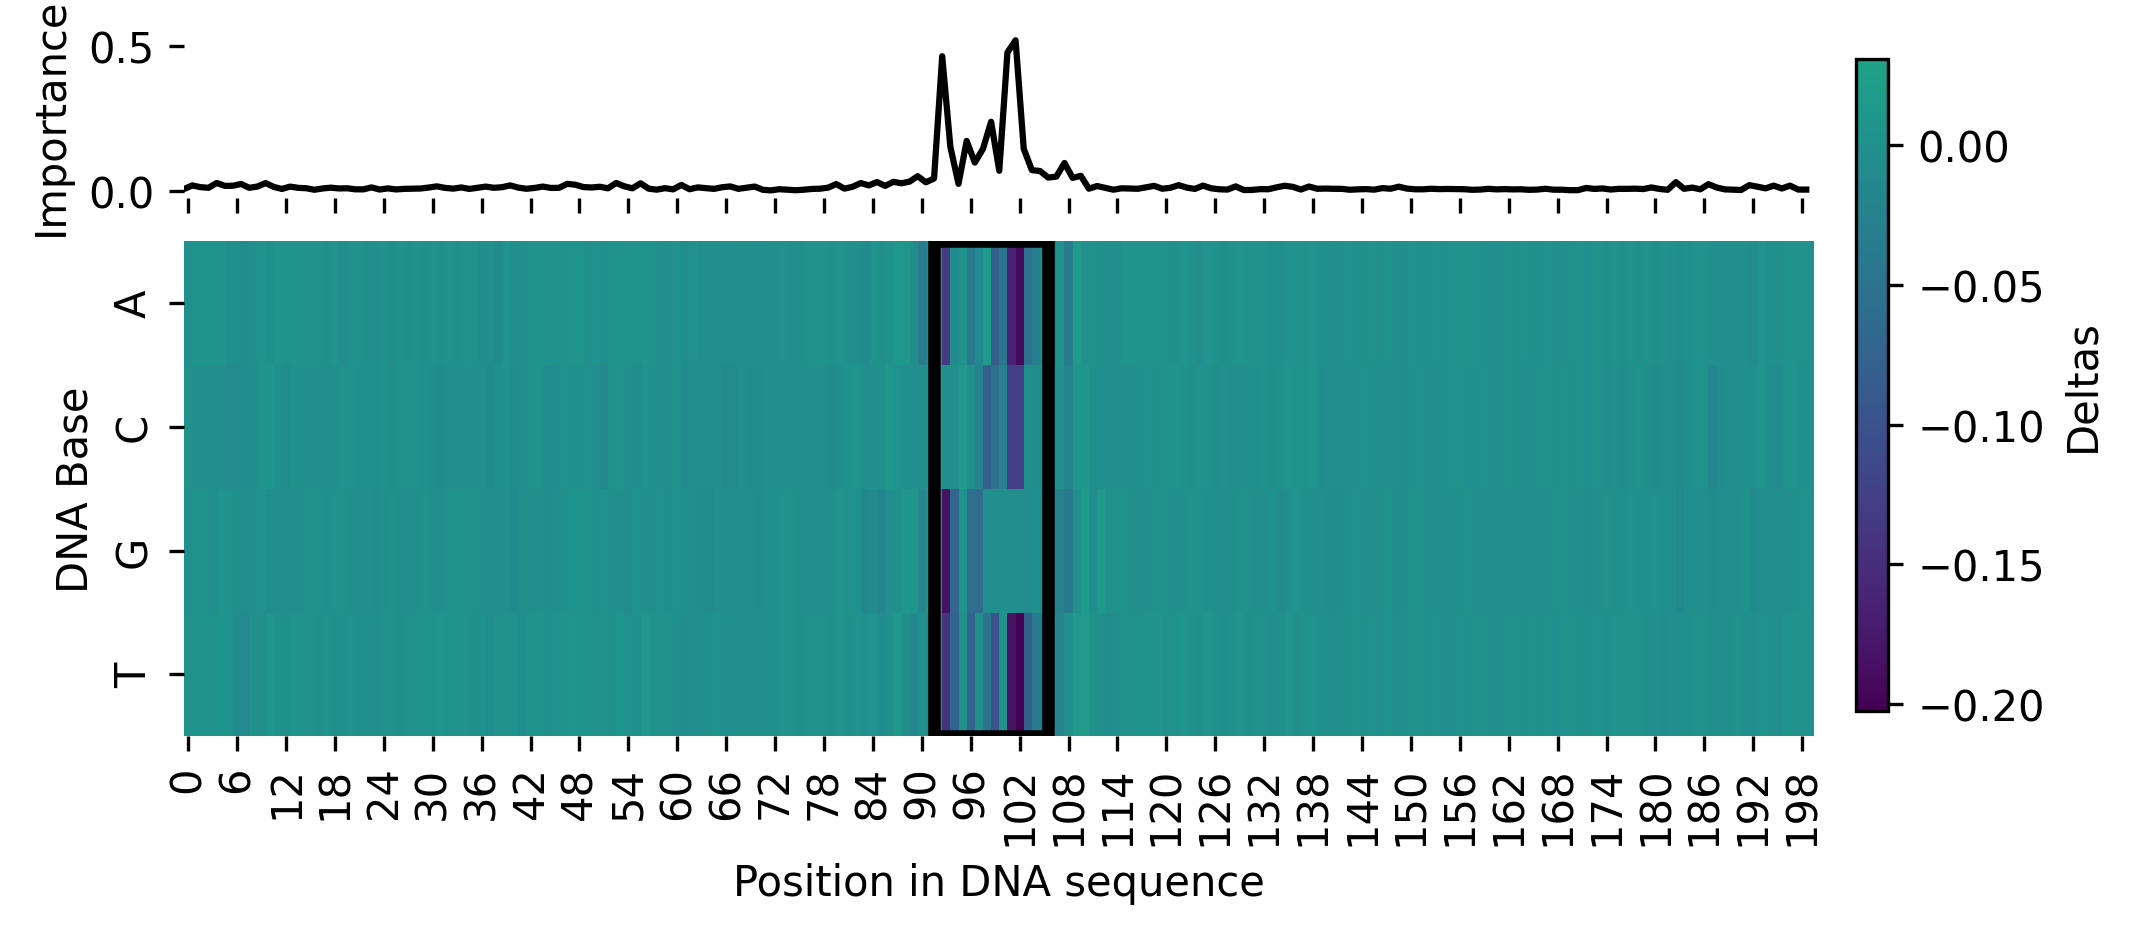

In [19]:
plot_binding_site(
  panels={
    "tiles": {"label": "Deltas", "values": deltas},
    "line": {"label": "Importance", "values": importance},
  },
  highlight=(92, 106),
);

#### 3.4.1.3. Implementing Input Gradients


In [20]:
from dlfb.dna.utils import compute_input_gradient

display([compute_input_gradient])

@jax.jit
def compute_input_gradient(state, sequence):
  """Compute input gradient for a one-hot DNA sequence."""
  if len(sequence.shape) != 2:
    raise ValueError("Input must be a single one-hot encoded DNA sequence.")

  sequence = jnp.asarray(sequence, dtype=jnp.float32)[None, :]

  def predict(sequence):
    # We take the mean to ensure we have a single scalar to take the grad of.
    return jnp.mean(state.apply_fn({"params": state.params}, sequence))

  gradient = jax.grad(lambda x: predict(x))(sequence)
  return jnp.squeeze(gradient)

In [21]:
input_gradient = compute_input_gradient(state, original_sequence)
input_gradient.shape

(200, 4)

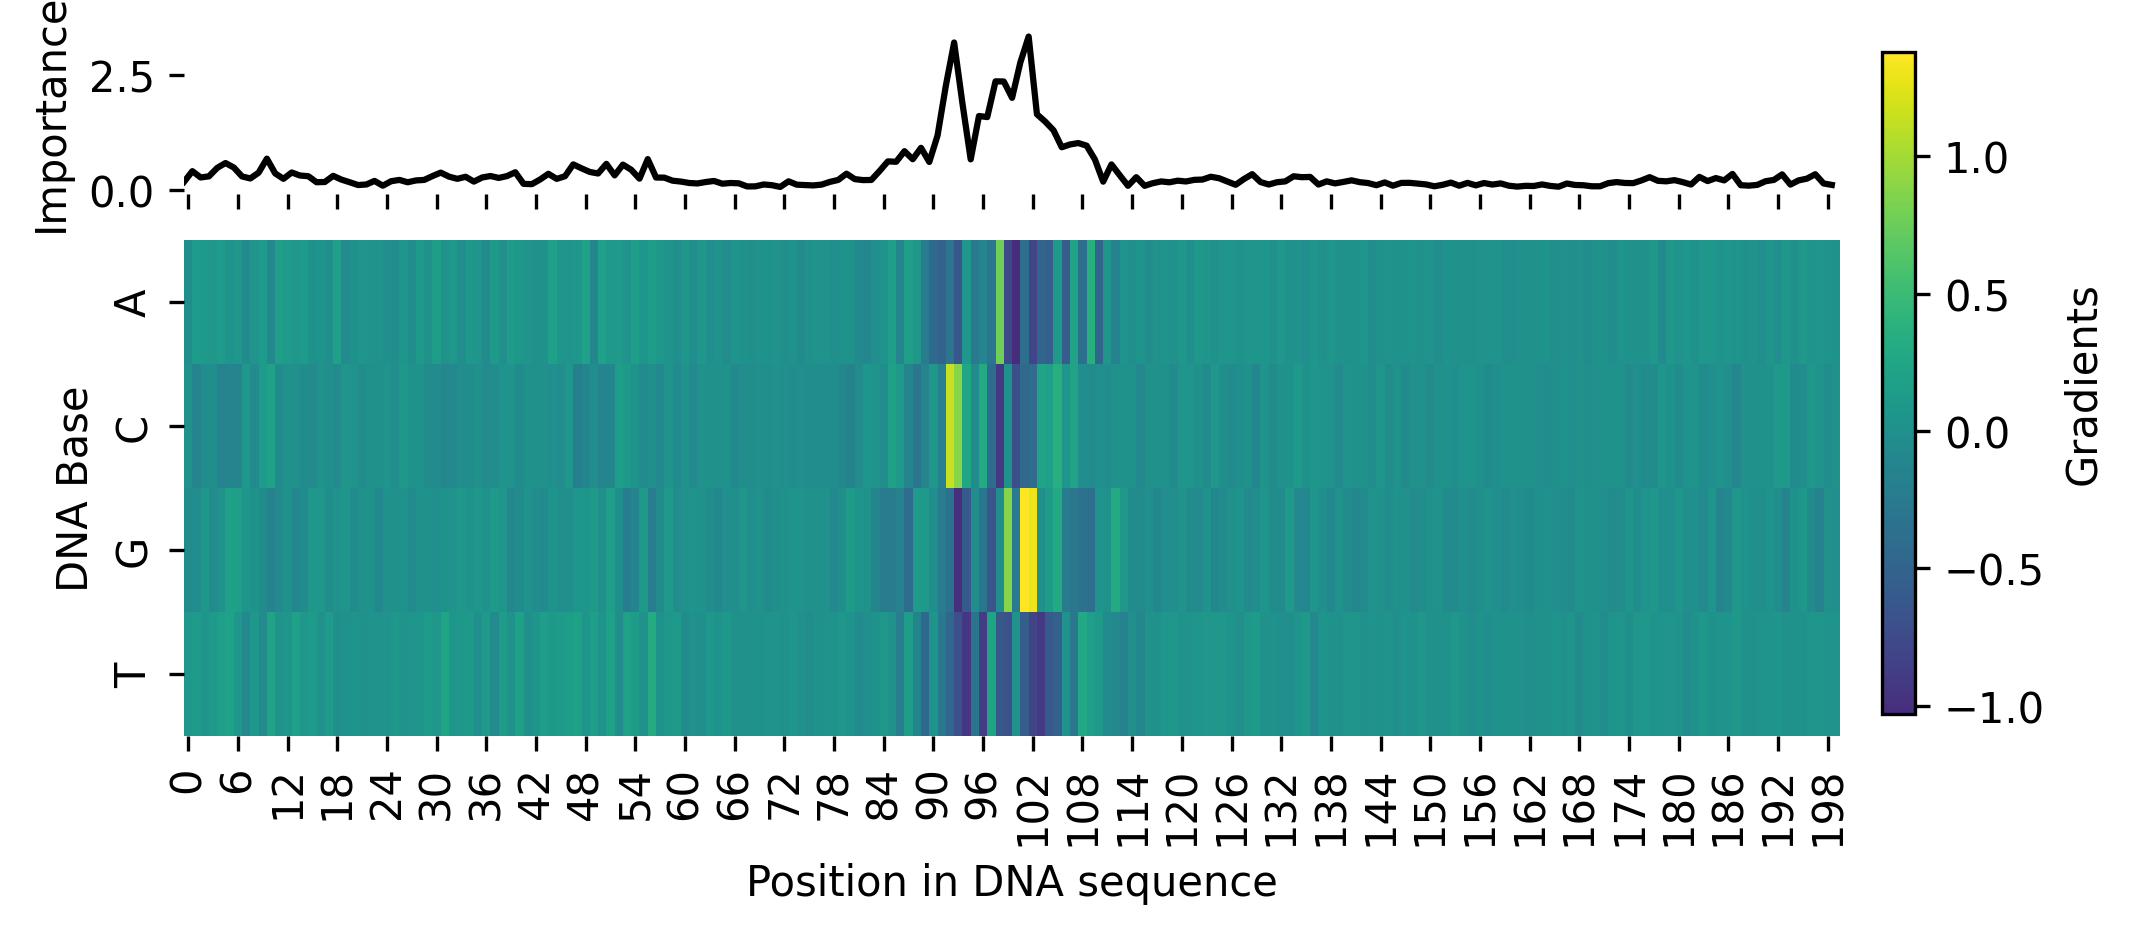

In [22]:
importance = np.sum(np.abs(input_gradient), axis=1)
plot_binding_site(
  panels={
    "tiles": {"label": "Gradients", "values": input_gradient},
    "line": {"label": "Importance", "values": importance},
  },
);

Central DNA sequence with high importance:  TGGCCTCTGGGGGCGCTCTG


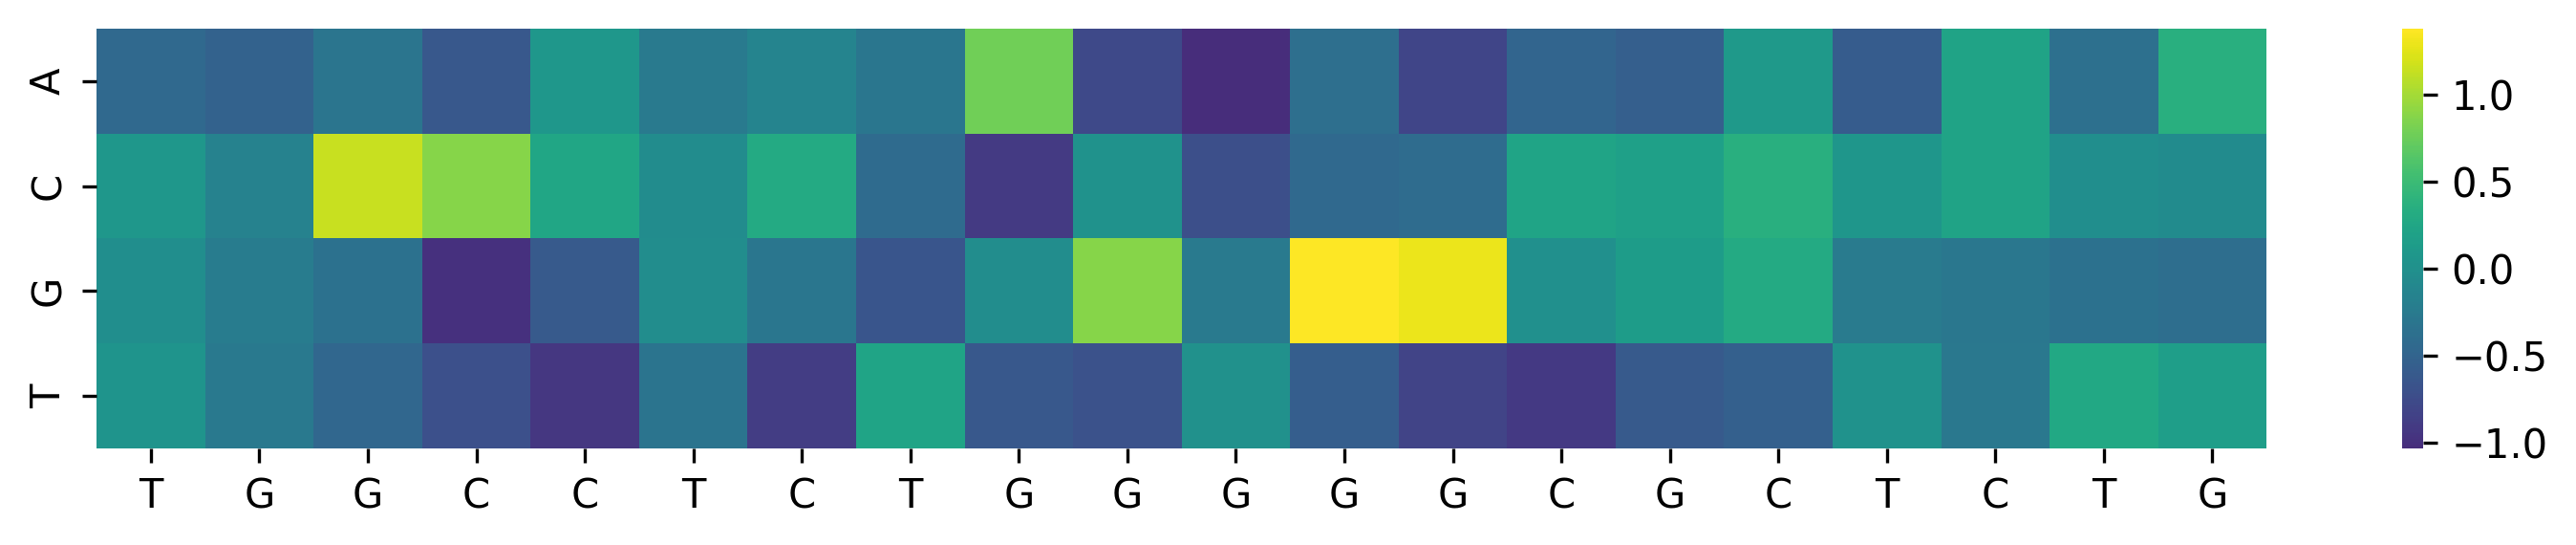

In [23]:
important_sequence = one_hot_to_dna(original_sequence)[90:110]
print("Central DNA sequence with high importance: ", important_sequence)

plt.figure(figsize=(10, 2))
sns.heatmap(
  input_gradient[90:110].T,
  cmap="viridis",
  center=0,
  xticklabels=important_sequence,
  yticklabels=["A", "C", "G", "T"],
)
plt.tight_layout();

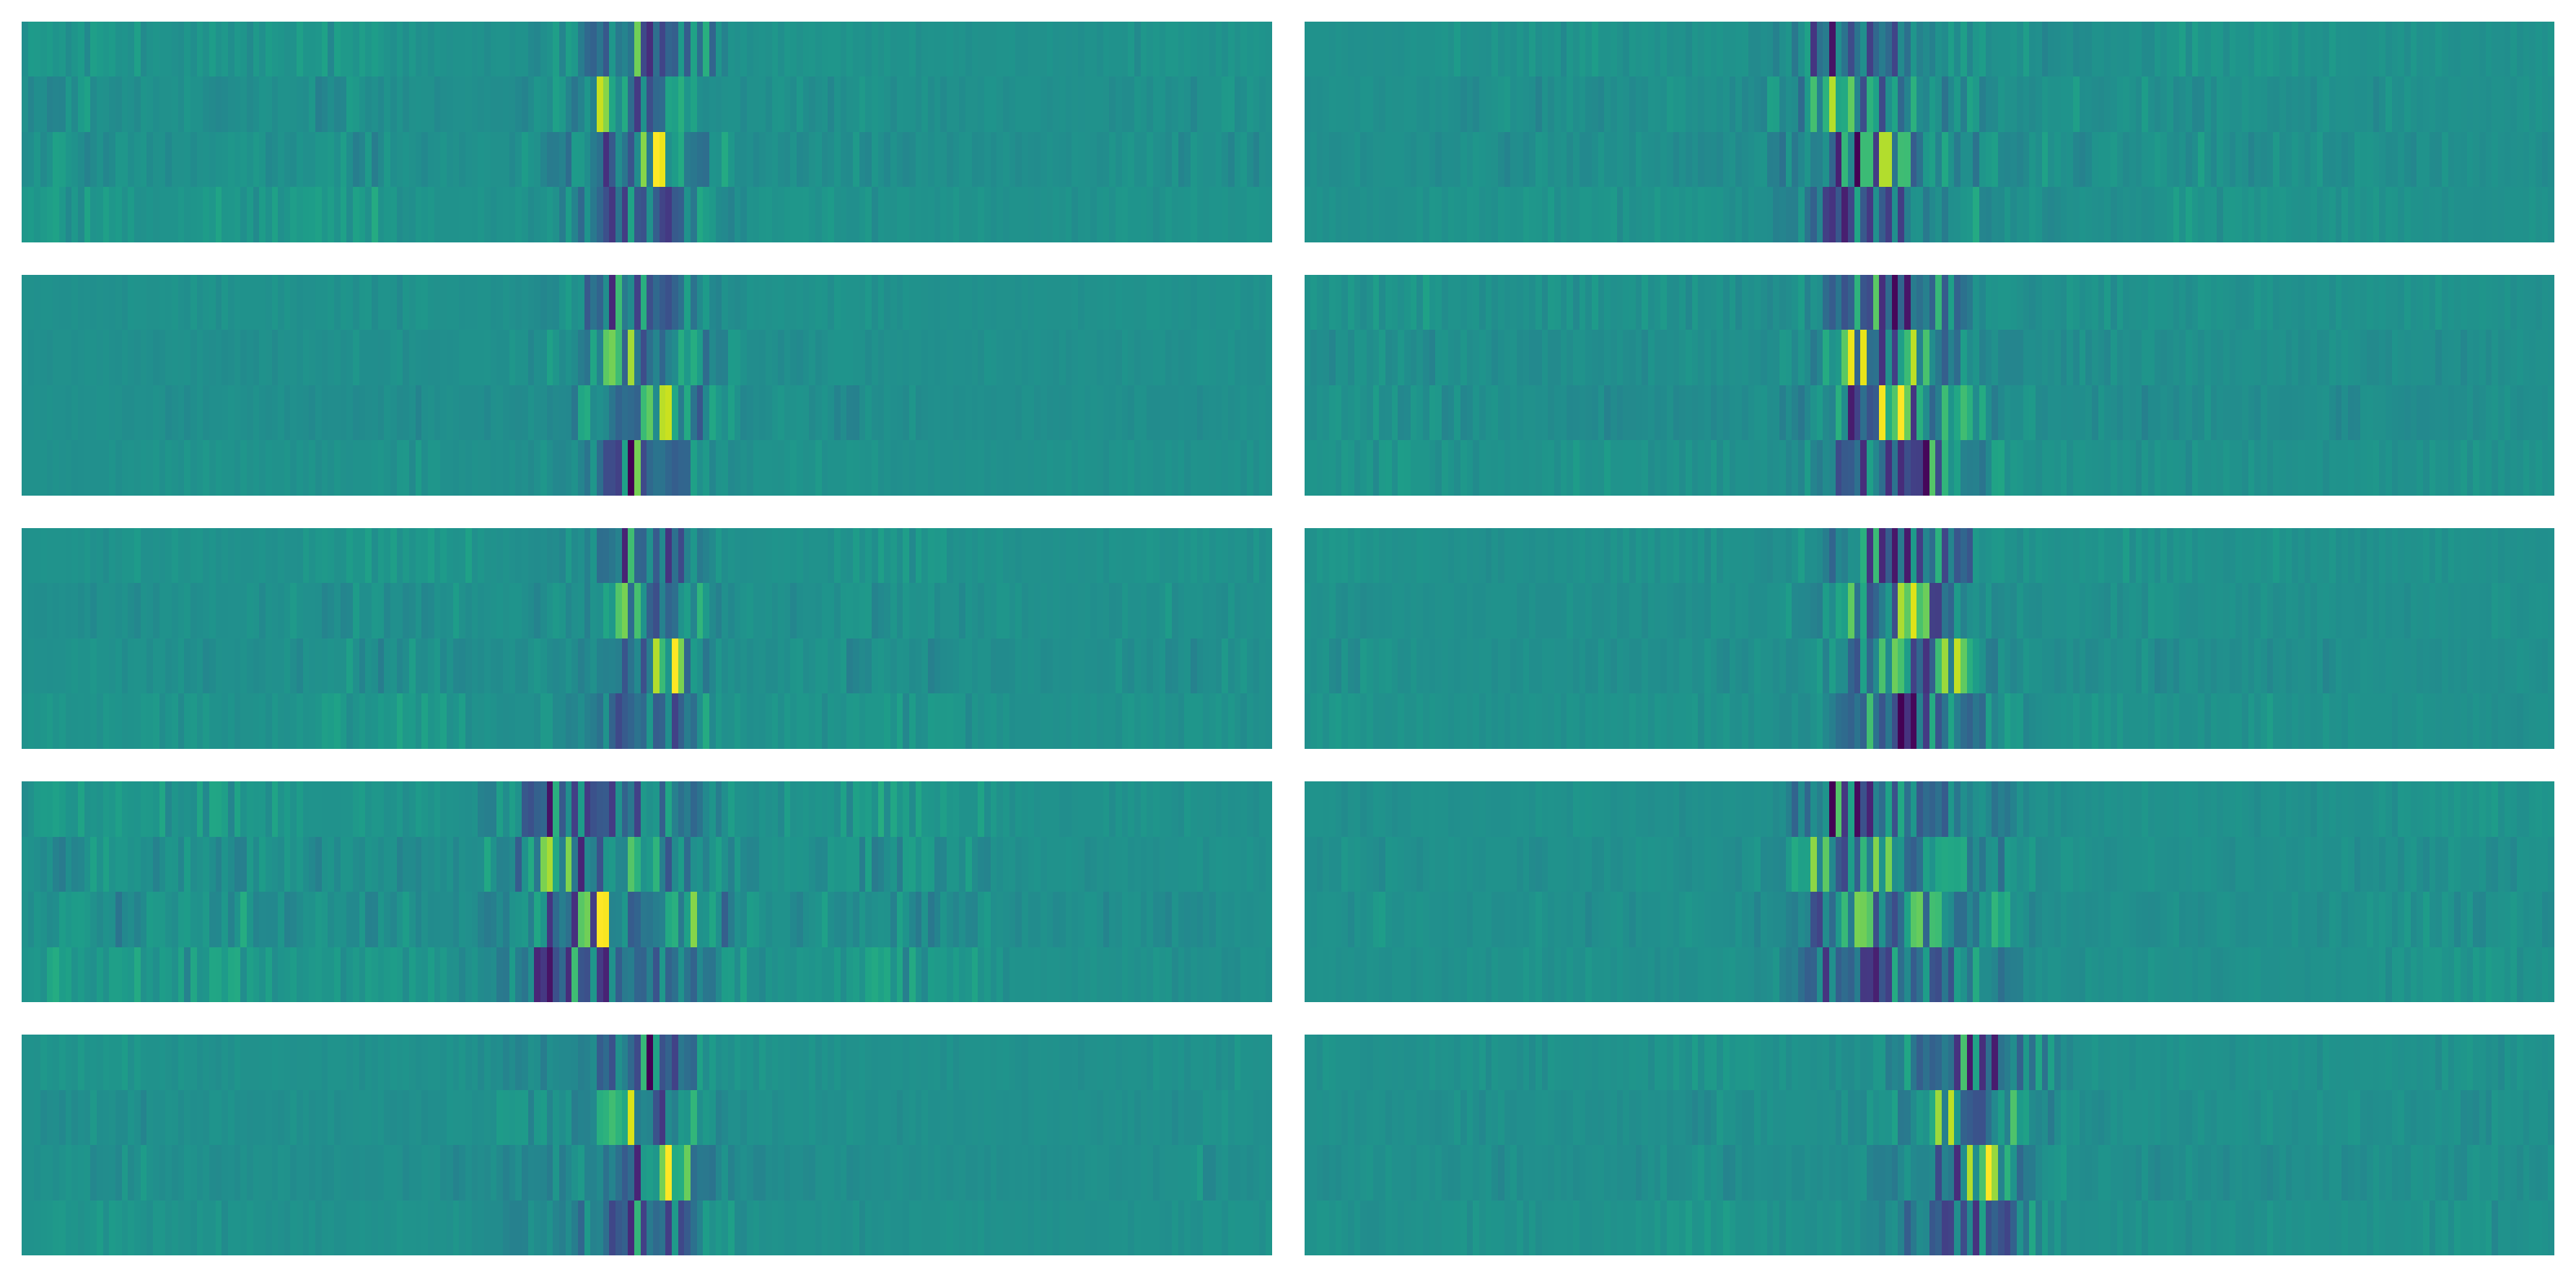

In [24]:
from dlfb.dna.inspect import plot_10_gradients

plot_10_gradients(state, valid_ds, target_label=1);

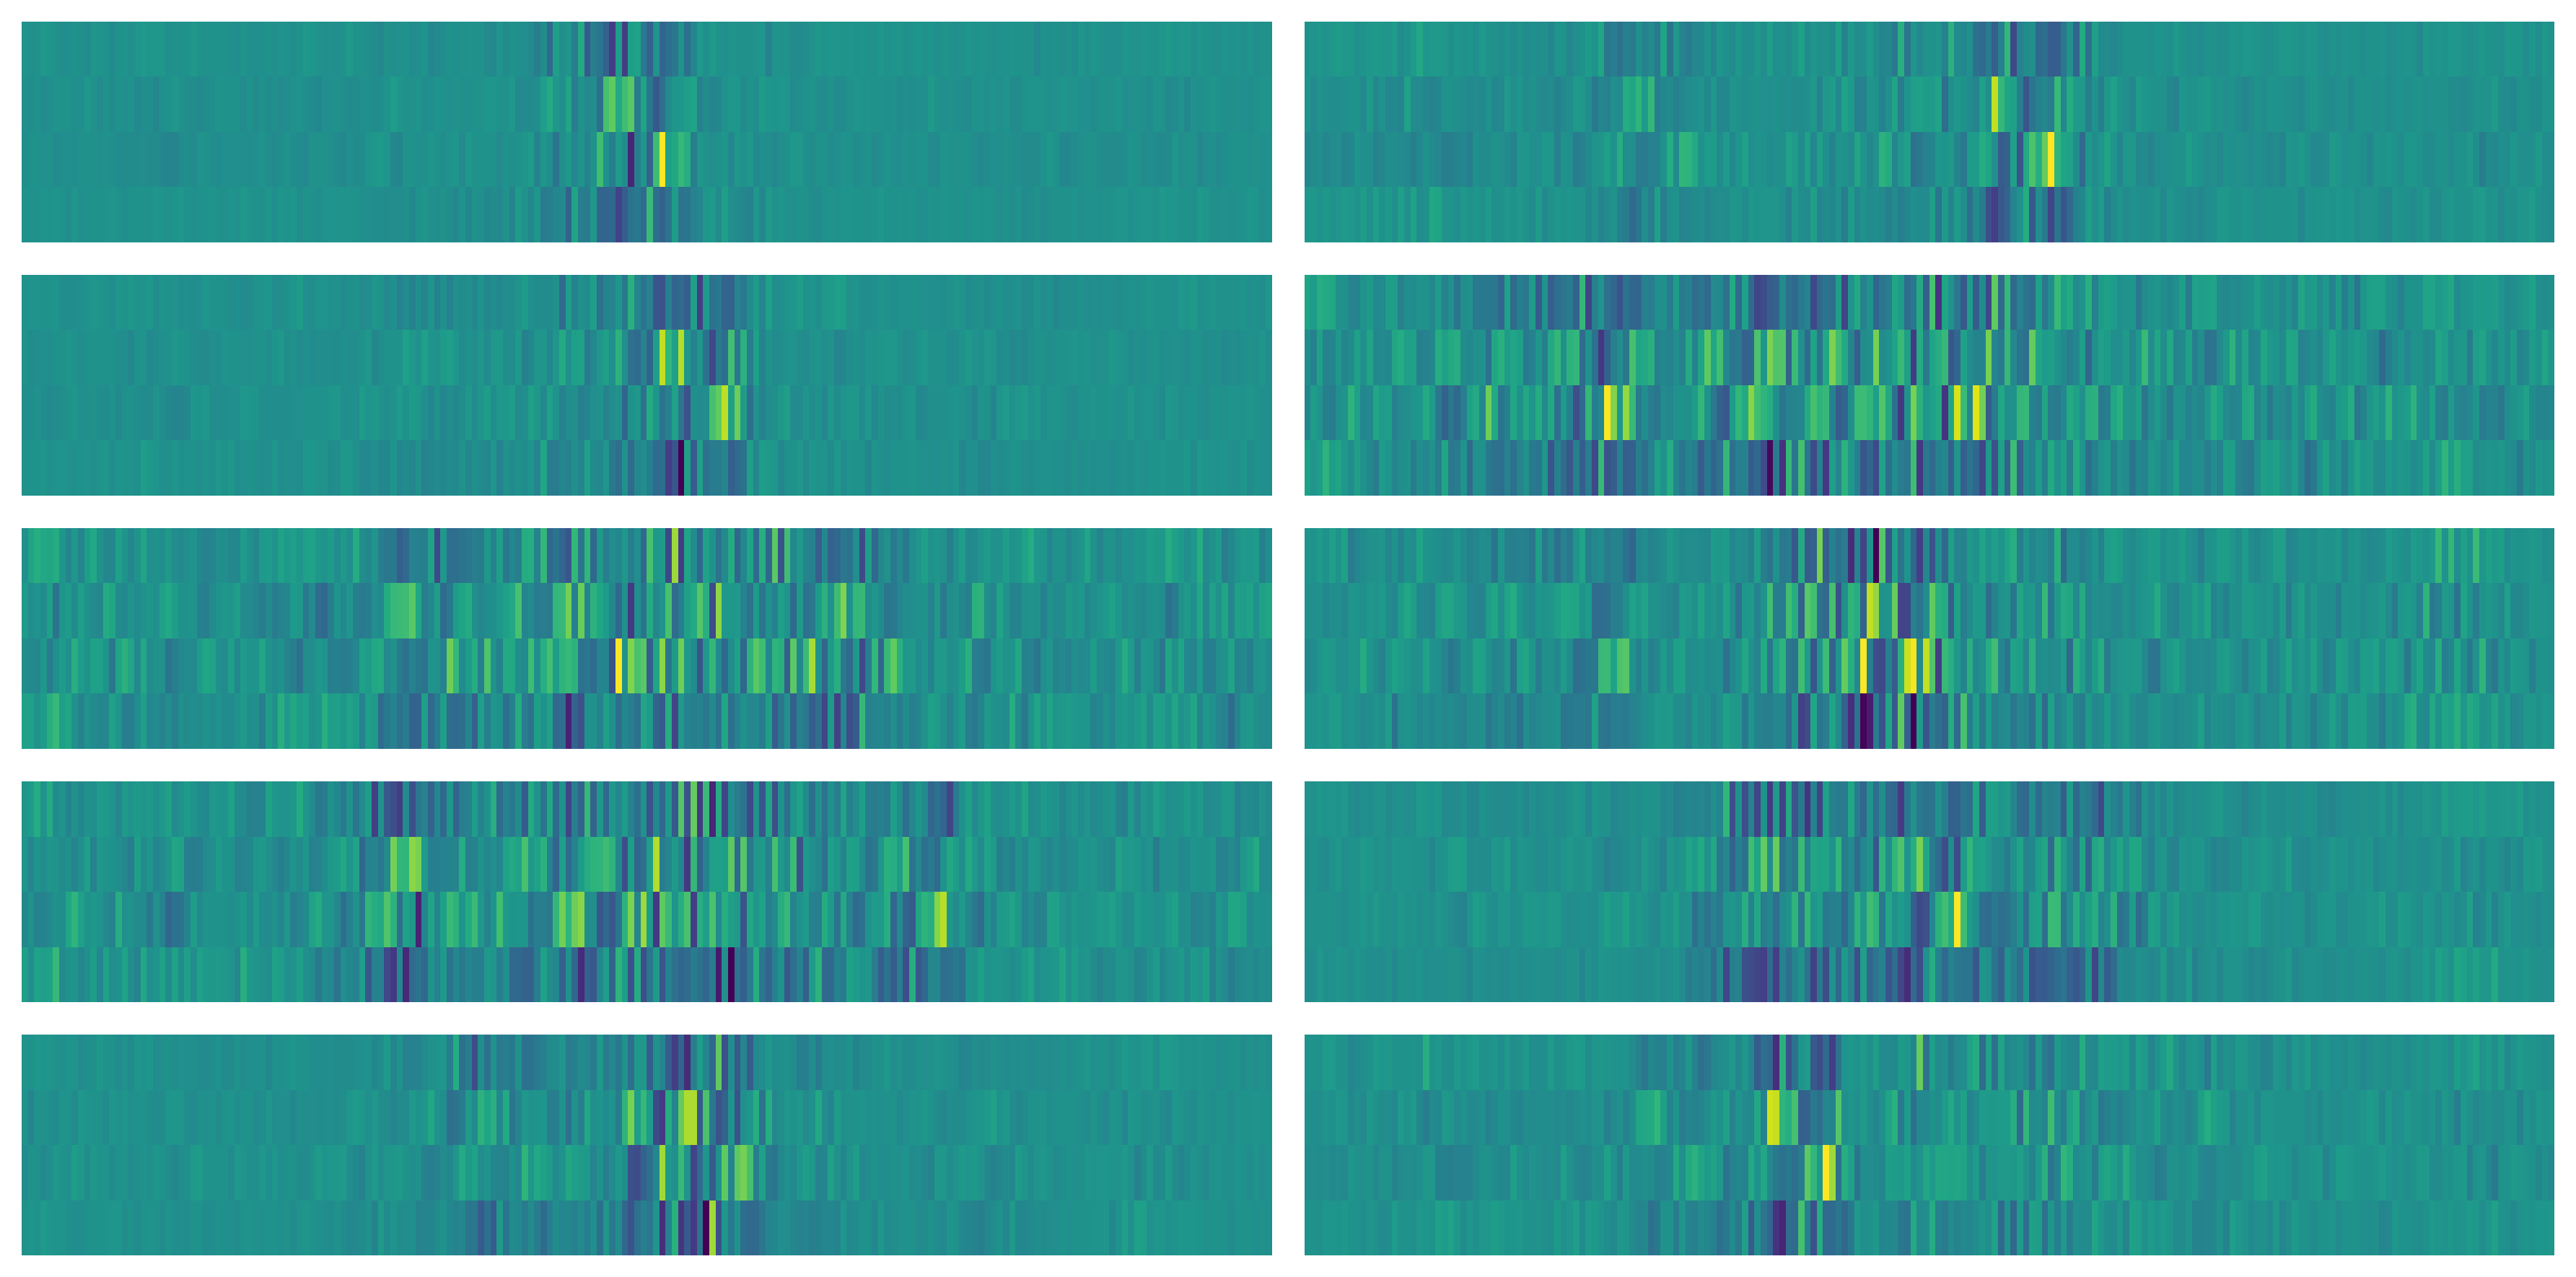

In [25]:
plot_10_gradients(state, valid_ds, target_label=0);

### 3.4.2. Modelling Multiple Transcription Factors
#### 3.4.2.1. Preparing a Multi-TF Dataset


In [3]:
transcription_factors = [
  "ARID3",
  "ATF2",
  "BACH1",
  "CTCF",
  "ELK1",
  "GABPA",
  "MAX",
  "REST",
  "SRF",
  "ZNF24",
]

#### 3.4.2.2. Defining a More Complex Model


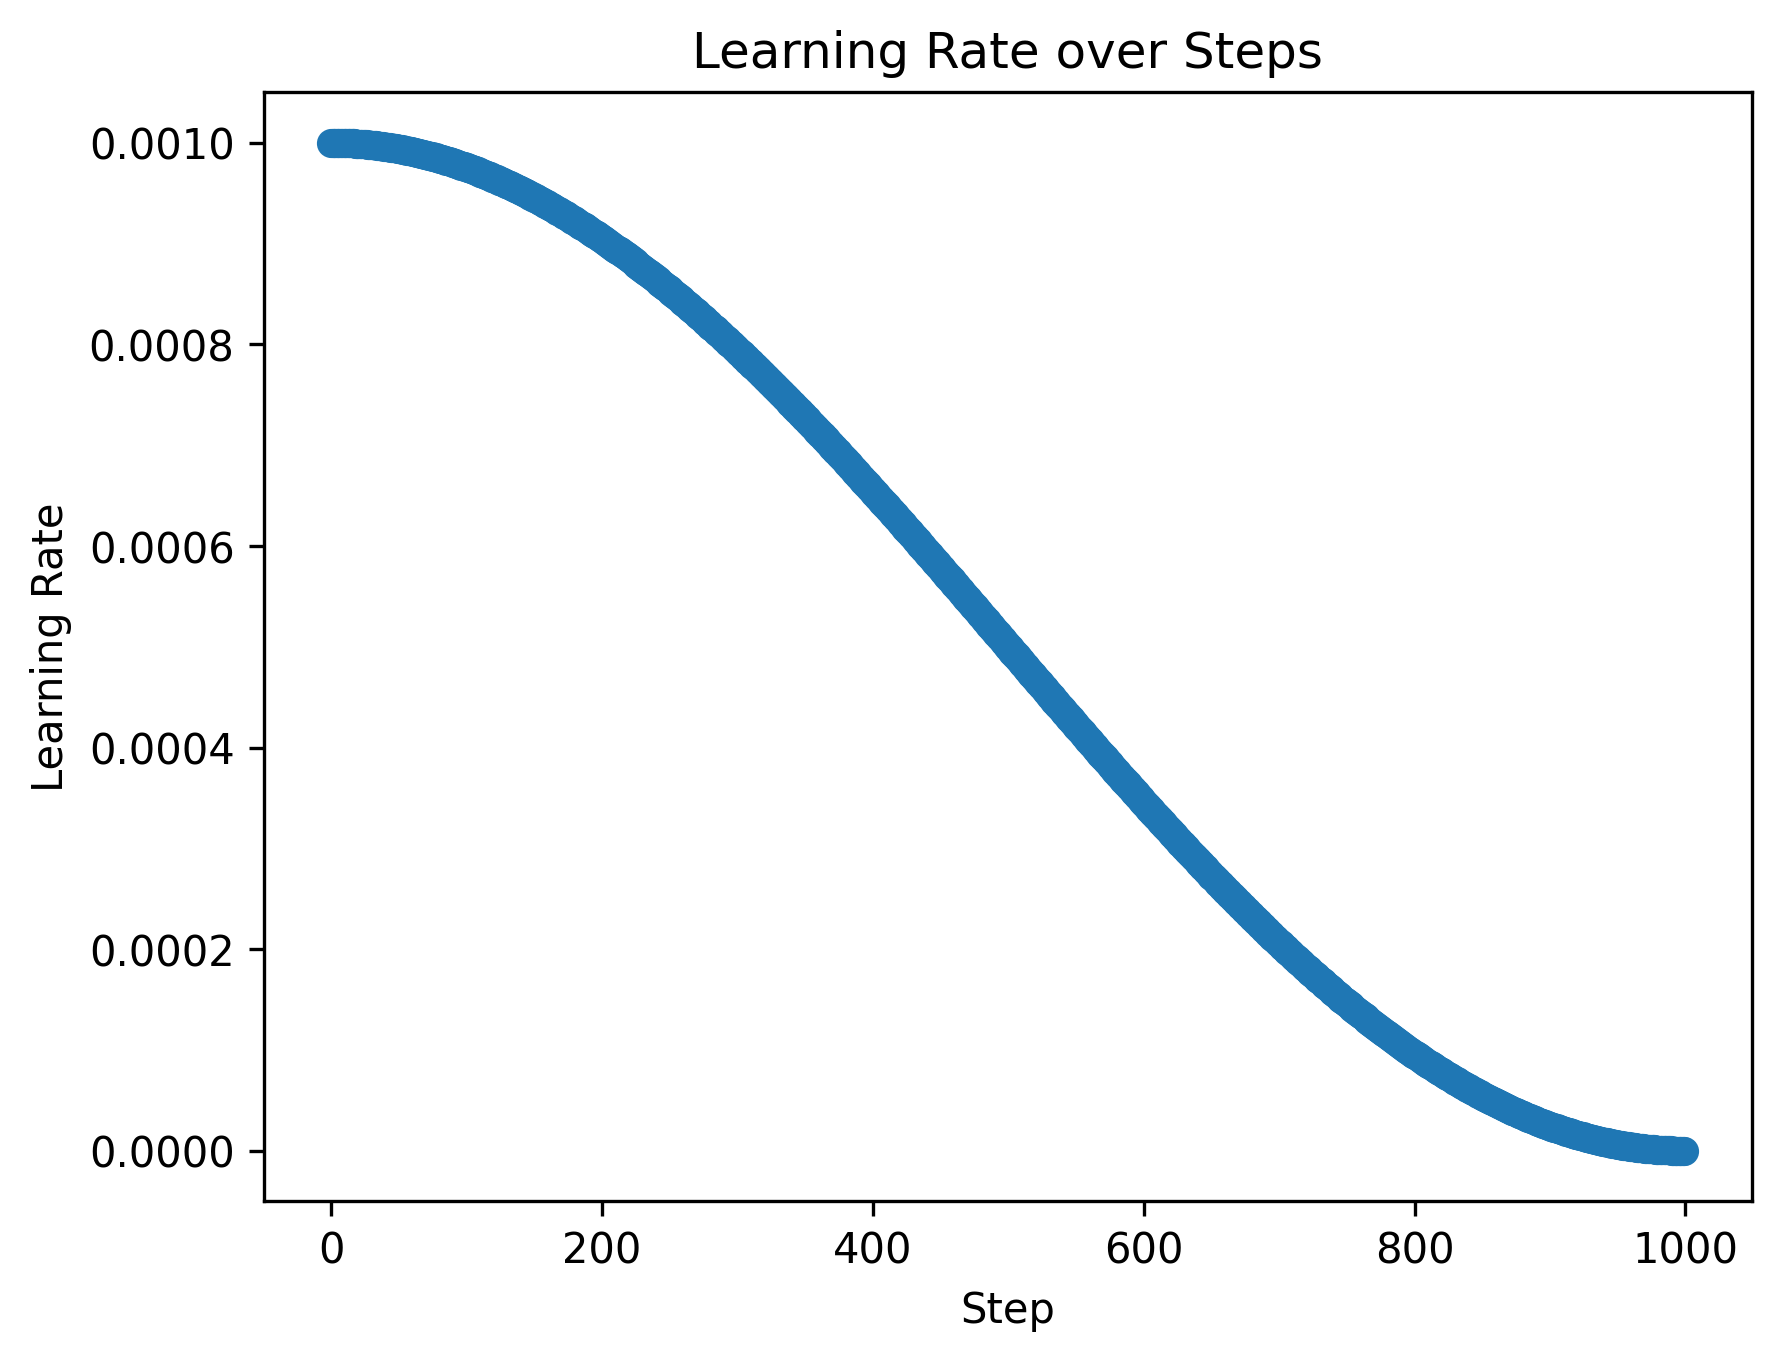

In [4]:
num_steps = 1000

scheduler = optax.cosine_decay_schedule(
  init_value=0.001,
  decay_steps=num_steps,  # How long to decay over.
)
learning_rates = [scheduler(i) for i in range(num_steps)]

plt.scatter(range(num_steps), learning_rates)
plt.title("Learning Rate over Steps")
plt.ylabel("Learning Rate")
plt.xlabel("Step");

In [5]:
from dlfb.dna.model import ConvModelV2

display([ConvModelV2])

class ConvModelV2(nn.Module):
  """CNN with batch norm and dropout for binary classification."""

  conv_filters: int = 64  # Number of filters for conv layers.
  kernel_size: tuple[int] = (10,)  # Kernel size for 1D conv layers.
  dense_units: int = 128  # Units in first dense fully connected layer.
  dropout_rate: float = 0.2  # Proportion of dense neurons to randomly drop out.

  @nn.compact
  def __call__(self, x, is_training: bool = True):
    # First convolutional layer.
    x = nn.Conv(
      features=self.conv_filters, kernel_size=self.kernel_size, padding="SAME"
    )(x)
    x = nn.BatchNorm(use_running_average=not is_training)(x)
    x = nn.gelu(x)
    x = nn.max_pool(x, window_shape=(2,), strides=(2,))

    # Second convolutional layer.
    x = nn.Conv(
      features=self.conv_filters, kernel_size=self.kernel_size, padding="SAME"
    )(x)
    x = nn.gelu(x)
    x = nn.BatchNorm(use_running_average=not is_training)(x)
    x = nn.max_pool(x, window_shape=(2,), strides=(2,))

    # Flatten the values before passing them to the dense layers.
    x = x.reshape((x.shape[0], -1))

    # First dense layer.
    x = nn.Dense(self.dense_units)(x)
    x = nn.gelu(x)
    x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not is_training)

    # Second dense layer.
    x = nn.Dense(self.dense_units // 2)(x)
    x = nn.gelu(x)
    x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not is_training)

    # Output layer (single unit for binary classification).
    return nn.Dense(1)(x)

  def create_train_state(self, rng: jax.Array, dummy_input, tx):
    """Initializes model parameters and returns a train state for training."""
    rng, rng_init, rng_dropout = jax.random.split(rng, 3)
    variables = self.init(rng_init, dummy_input)
    state = TrainStateWithBatchNorm.create(
      apply_fn=self.apply,
      tx=tx,
      params=variables["params"],
      batch_stats=variables["batch_stats"],
      key=rng_dropout,
    )
    return state

In [6]:
rng = jax.random.PRNGKey(42)
rng, rng_init, rng_train = jax.random.split(rng, 3)
state = ConvModelV2().create_train_state(
  rng=rng_init, dummy_input=batch["sequences"], tx=optax.adam(scheduler)
)

In [7]:
from dlfb.dna.train import train_step

display([train_step])

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


@jax.jit
def train_step(state, batch, rng_dropout: jax.Array):
  """Run a training step and update parameters."""

  def calculate_loss(params, batch):
    """Make predictions on batch and compute binary cross-entropy loss."""
    logits, updates = state.apply_fn(
      {"params": params, "batch_stats": state.batch_stats},
      x=batch["sequences"],
      is_training=True,
      rngs={"dropout": rng_dropout},
      mutable=["batch_stats"],
    )

    loss = optax.sigmoid_binary_cross_entropy(logits, batch["labels"]).mean()

    return loss, updates

  grad_fn = jax.value_and_grad(calculate_loss, has_aux=True)
  (loss, updates), grads = grad_fn(state.params, batch)
  state = state.apply_gradients(grads=grads)
  state = state.replace(batch_stats=updates["batch_stats"])

  metrics = {"loss": loss}

  return state, metrics

In [8]:
# Overfit on one batch.
for i in range(5):
  rng, rng_dropout = jax.random.split(rng, 2)
  state, metrics = train_step(state, batch, rng_dropout)
  print(f"Step {i} loss: {metrics['loss']}")

Step 0 loss: 0.6783099174499512
Step 1 loss: 0.2872534692287445
Step 2 loss: 0.10477680712938309
Step 3 loss: 0.056741707026958466
Step 4 loss: 0.027774784713983536


In [9]:
from dlfb.dna.train import compute_metrics, eval_step

display([eval_step, compute_metrics])

def eval_step(state, batch):
  """Evaluate model on a single batch."""
  logits = state.apply_fn(
    {"params": state.params, "batch_stats": state.batch_stats},
    x=batch["sequences"],
    is_training=False,
    mutable=False,
  )
  loss = optax.sigmoid_binary_cross_entropy(logits, batch["labels"]).mean()
  metrics = {
    "loss": loss.item(),
    **compute_metrics(batch["labels"], logits),
  }
  return metrics


def compute_metrics(y_true: np.ndarray, logits: np.ndarray):
  """Compute accuracy and auROC for model predictions."""
  metrics = {
    "accuracy": accuracy_score(y_true, nn.sigmoid(logits) >= 0.5),
    "auc": roc_auc_score(y_true, logits).item(),
  }
  return metrics

In [10]:
# Evaluate the batch.
metrics = eval_step(state, batch)
print(metrics)

{'loss': 0.49056100845336914, 'accuracy': 1.0, 'auc': 1.0}


In [11]:
from dlfb.dna.train import train

display([train])

@restorable
def train(
  state: TrainStateWithBatchNorm,
  rng: jax.Array,
  dataset_splits: dict[str, tf.data.Dataset],
  num_steps: int,
  eval_every: int = 100,
) -> tuple[TrainStateWithBatchNorm, Any]:
  """Train a model and log metrics over steps."""
  metrics = MetricsLogger()
  train_batches = dataset_splits["train"].as_numpy_iterator()

  steps = tqdm(range(num_steps))  # Steps with progress bar.
  for step in steps:
    steps.set_description(f"Step {step + 1}")

    rng, rng_dropout = jax.random.split(rng, 2)
    train_batch = next(train_batches)
    state, batch_metrics = train_step(state, train_batch, rng_dropout)
    metrics.log_step(split="train", **batch_metrics)

    if step % eval_every == 0:
      for eval_batch in dataset_splits["valid"].as_numpy_iterator():
        batch_metrics = eval_step(state, eval_batch)
        metrics.log_step(split="valid", **batch_metrics)
      metrics.flush(step=step)

    steps.set_postfix_str(metrics.latest(["loss"]))

  return state, metrics.export()

In [12]:
from dlfb.dna.dataset import load_dataset_splits

display([load_dataset_splits])

def load_dataset_splits(
  path, transcription_factor, batch_size: int | None = None
):
  """Load TF dataset splits (train, valid, test) as TensorFlow datasets."""
  dataset_splits = {}
  for split in ["train", "valid", "test"]:
    dataset = load_dataset(
      sequence_db=f"{path}/{transcription_factor}_{split}_sequences.csv"
    )
    ds = convert_to_tfds(dataset, batch_size, is_training=(split == "train"))
    dataset_splits.update({split: ds})
  return dataset_splits

In [13]:
prefix = assets("dna/datasets")
tf_metrics = {}

# Train one model per transcription factor.
for transcription_factor in transcription_factors:
  # Load data for this TF.
  dataset_splits = load_dataset_splits(
    assets("dna/datasets"), transcription_factor, batch_size
  )
  rng = jax.random.PRNGKey(42)
  rng, rng_init, rng_train = jax.random.split(rng, 3)
  dummy_batch = next(dataset_splits["train"].as_numpy_iterator())["sequences"]

  # Create train state.
  state = ConvModelV2().create_train_state(
    rng=rng_init,
    dummy_input=dummy_batch,
    tx=optax.adam(scheduler),
  )

  # Train the model.
  _, metrics = train(
    state=state,
    rng=rng_train,
    dataset_splits=dataset_splits,
    num_steps=num_steps,
    eval_every=100,
    store_path=assets(f"dna/models/{transcription_factor}"),
  )

  # Store metrics.
  tf_metrics.update({transcription_factor: metrics})

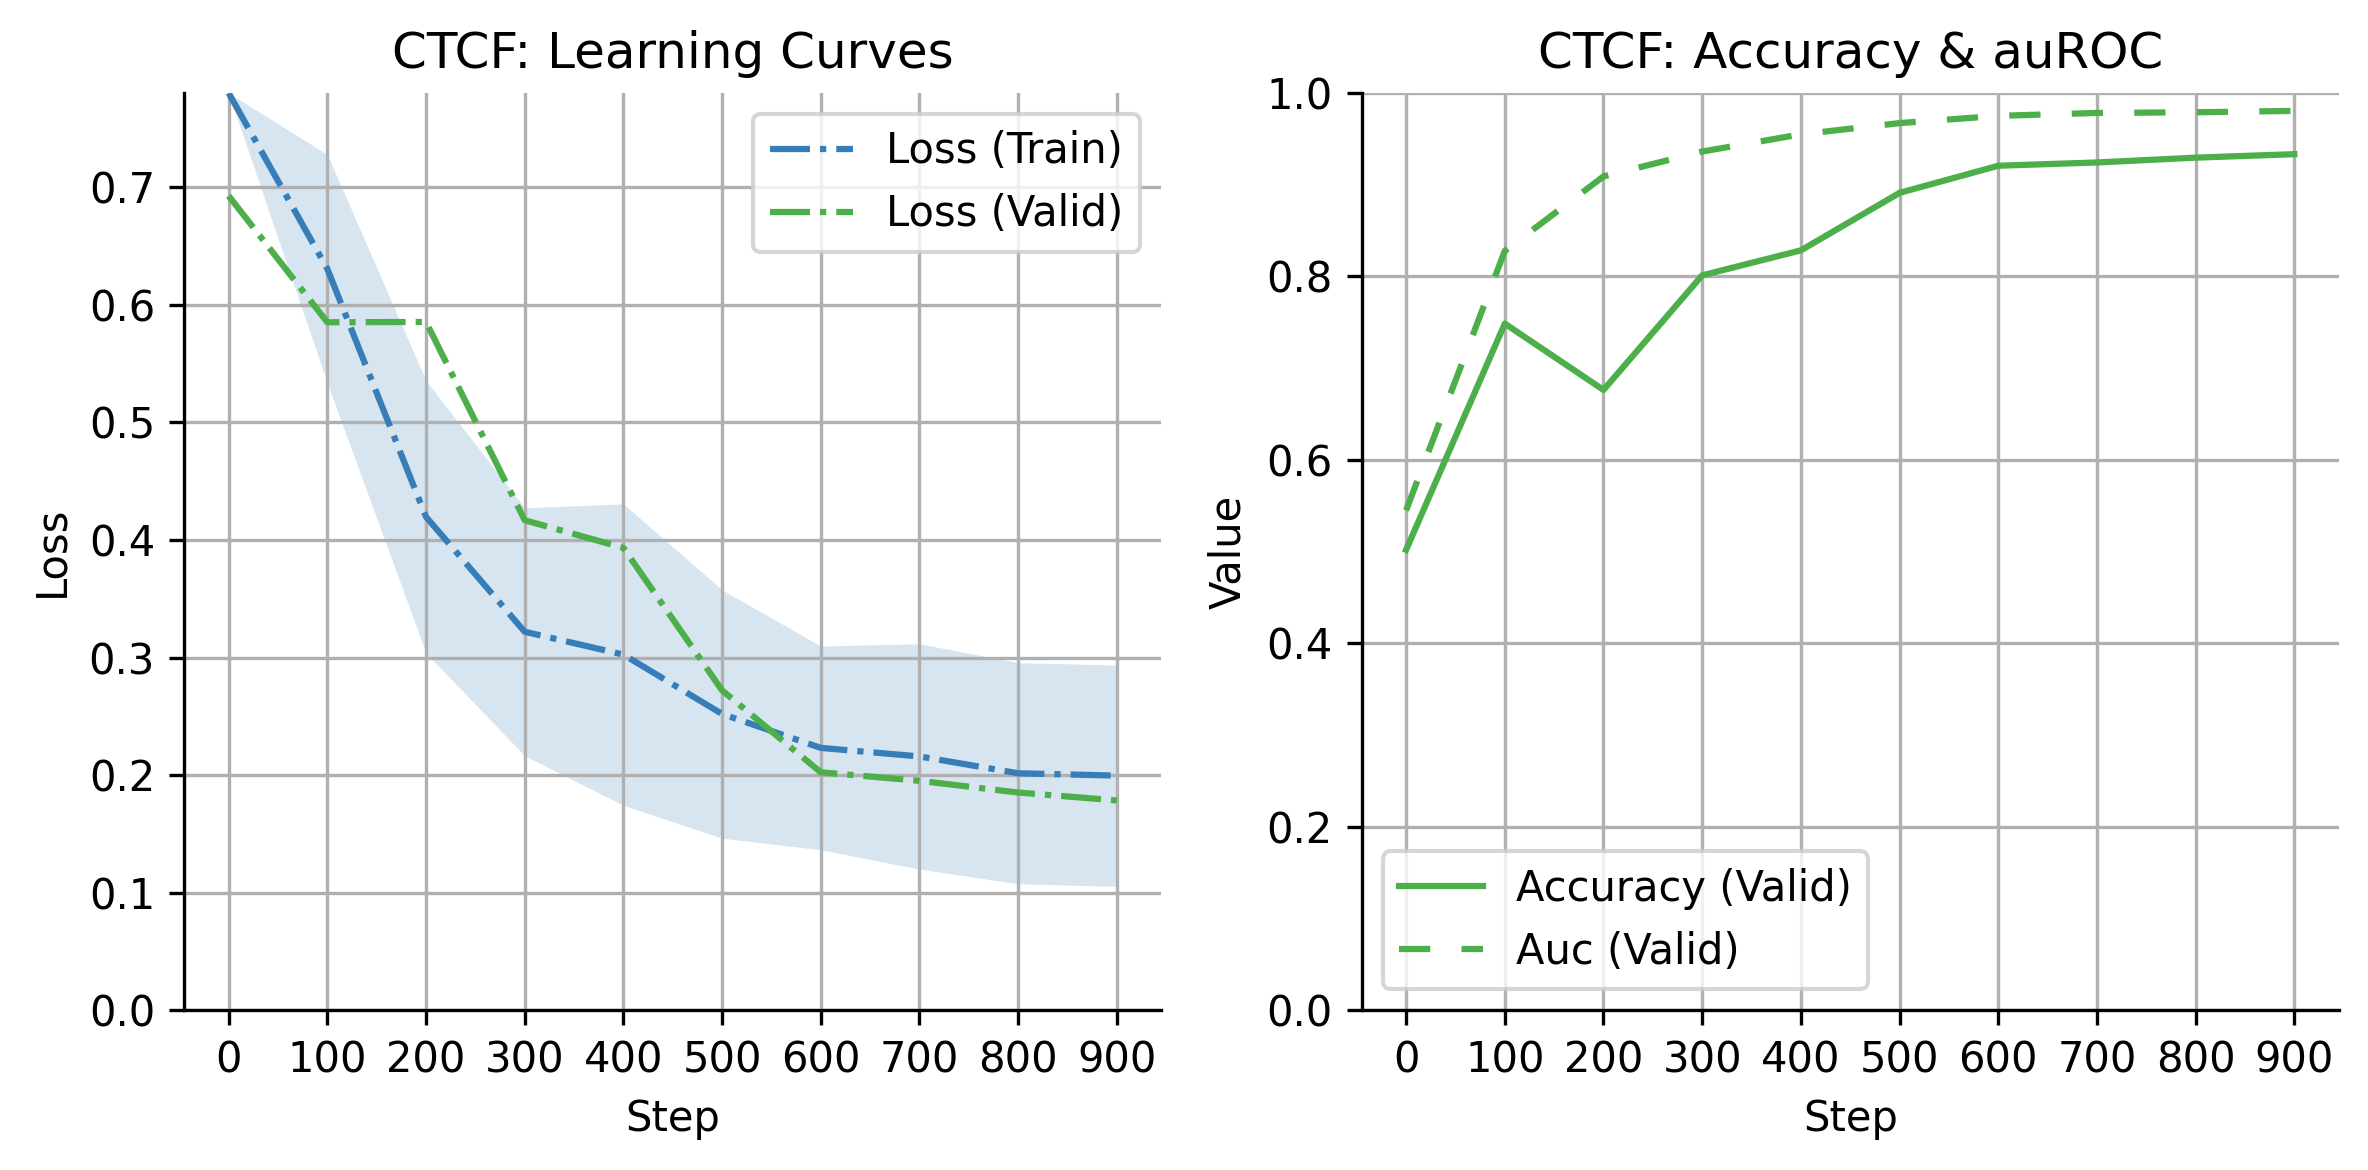

In [14]:
from dlfb.dna.inspect import plot_learning

tf = "CTCF"
plot_learning(tf_metrics[tf], tf);

In [15]:
from dlfb.utils.metric_plots import to_df

# Extract metrics logged per transcription factor.
tf_df = []
for tf, metrics in tf_metrics.items():
  tf_df.append(to_df(metrics).assign(TF=tf))
tf_df = pd.concat(tf_df)

# Determine order of best performance.
auc_df = tf_df[(tf_df["metric"] == "auc") & (tf_df["split"] == "valid")]
max_auc_by_tf = auc_df.groupby("TF")["mean"].max()
tf_order = max_auc_by_tf.sort_values(ascending=False).index.tolist()
tf_df["TF"] = pd.Categorical(tf_df["TF"], categories=tf_order, ordered=True)

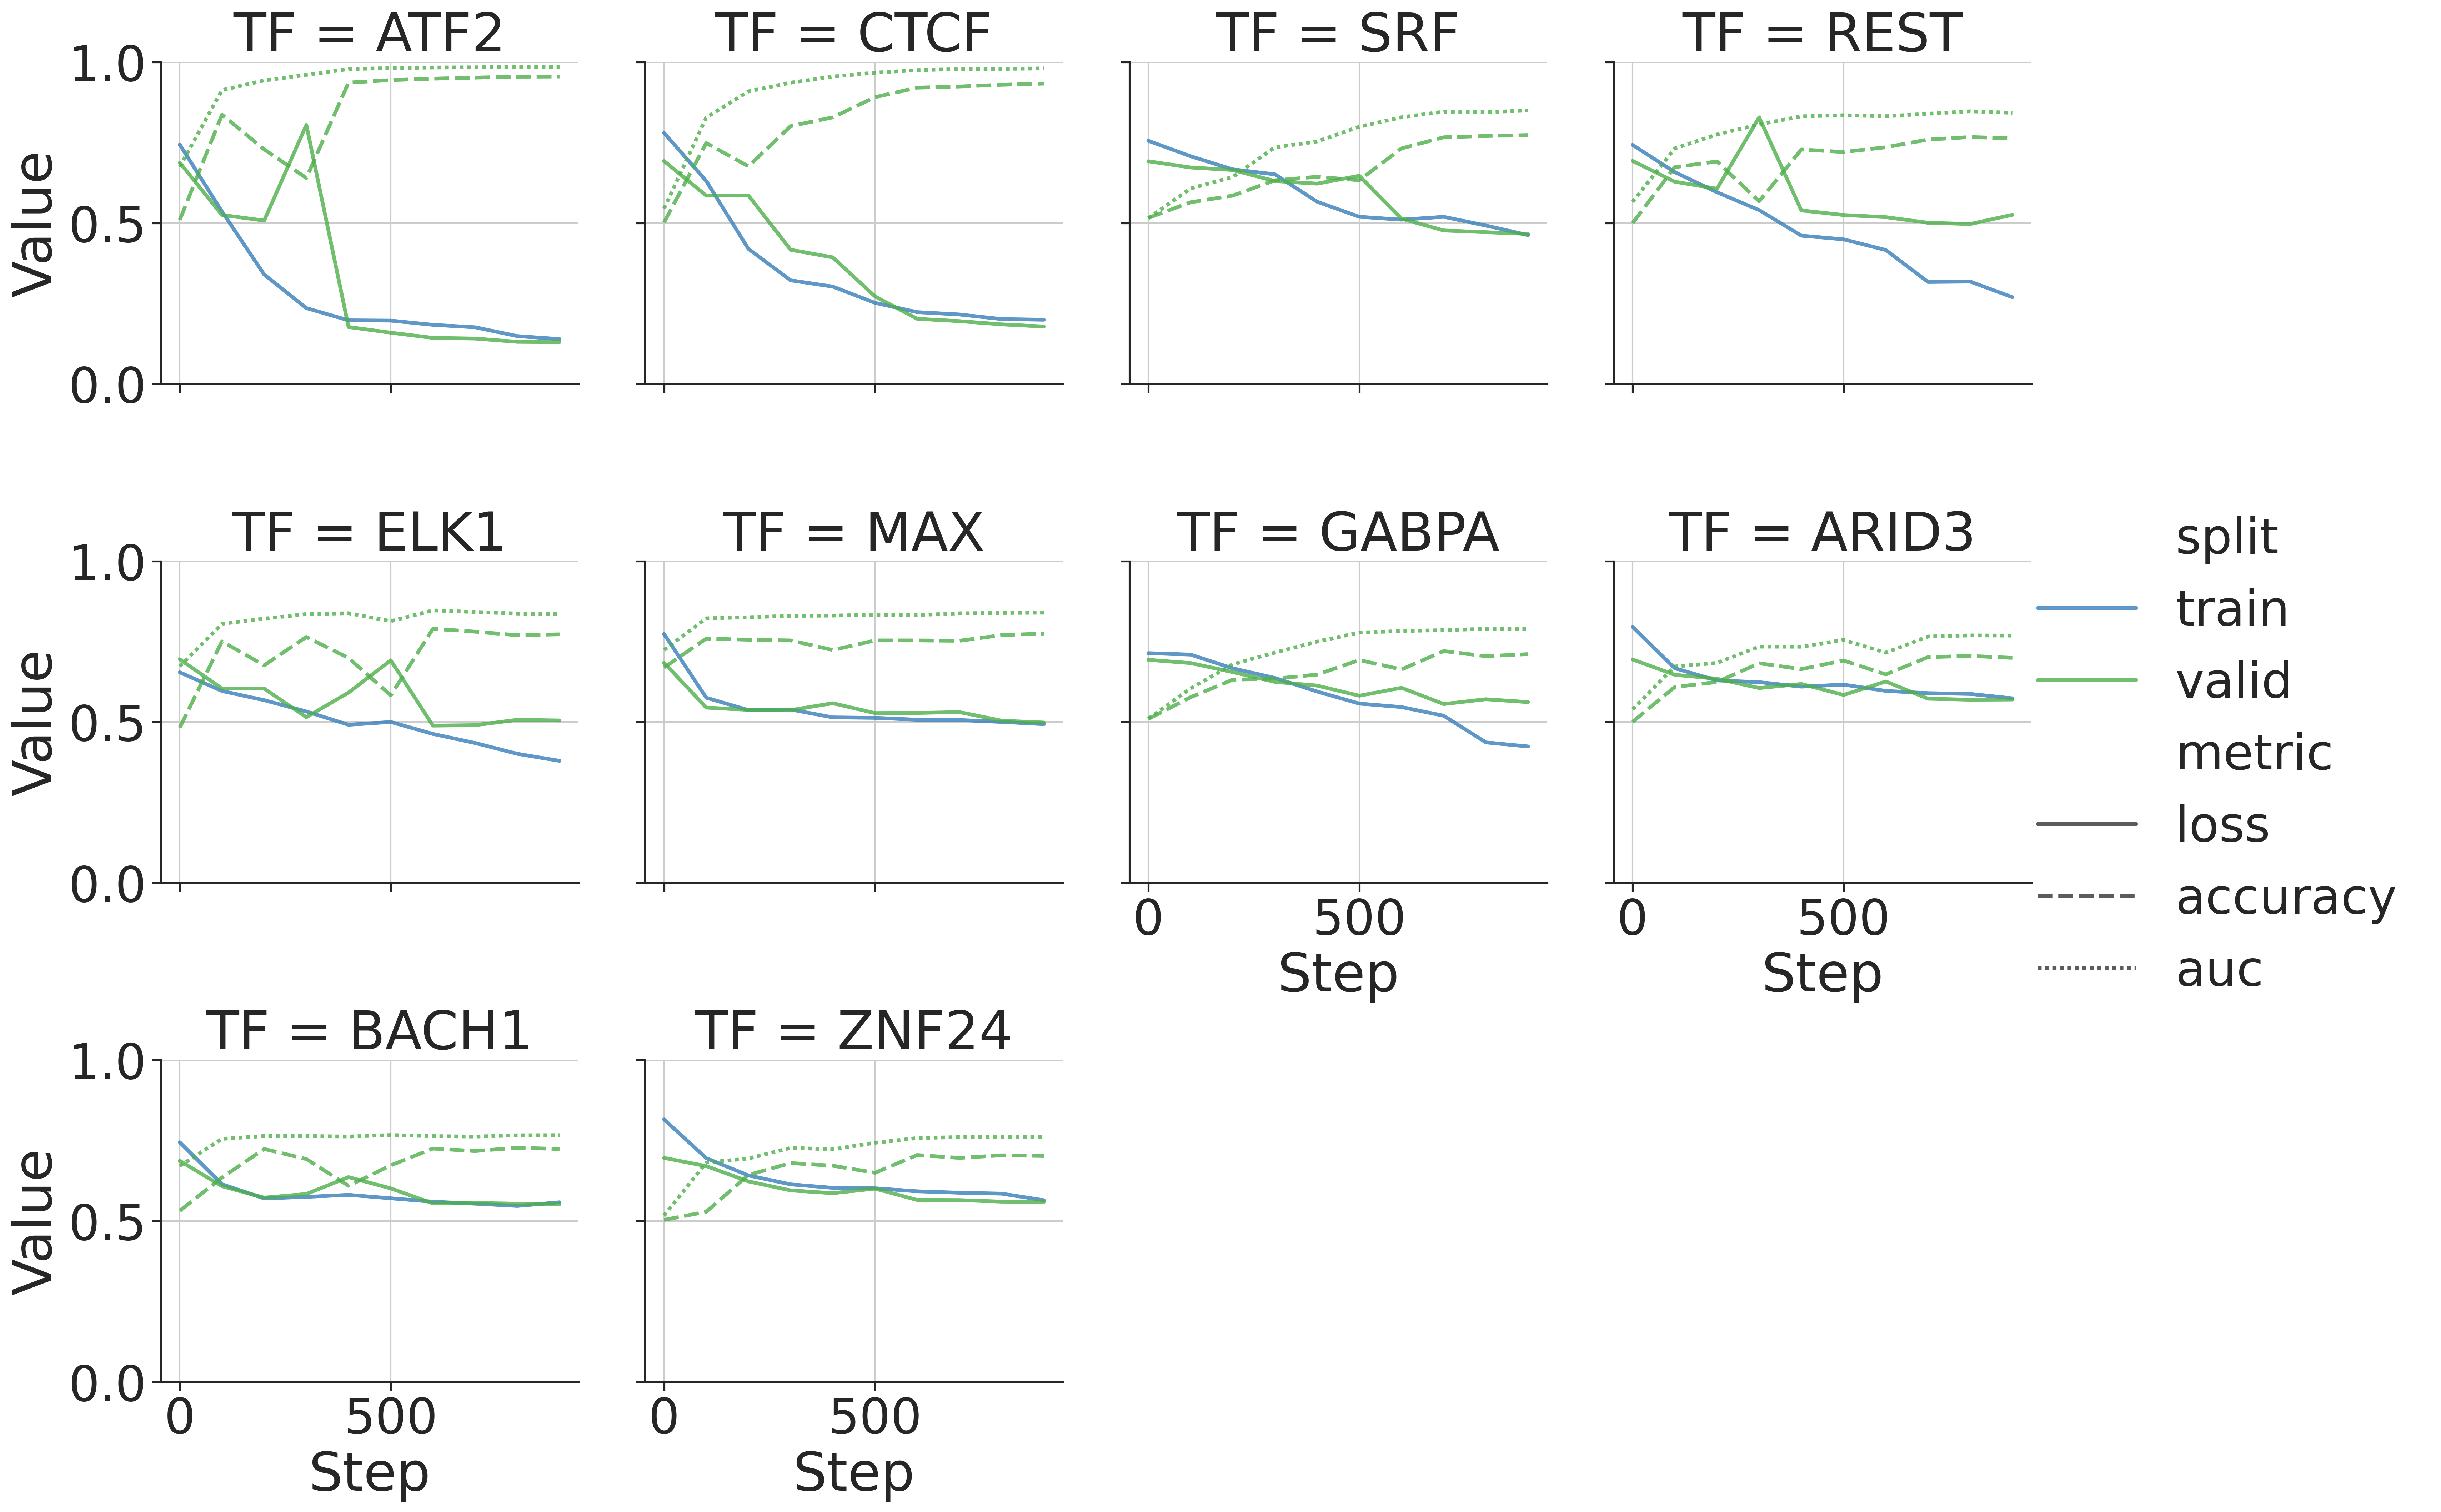

In [16]:
sns.set_context("notebook", font_scale=3, rc={"lines.linewidth": 2.5})
sns.set_style("ticks", {"axes.grid": True})
g = sns.relplot(
  data=tf_df,
  x="round",
  y="mean",
  hue="split",
  style="metric",
  kind="line",
  col="TF",
  col_order=tf_order,
  col_wrap=4,
  alpha=0.8,
  palette=DEFAULT_SPLIT_COLORS,
  dashes=True,
)
g.set_axis_labels("Step", "Value")
g.set(ylim=(0, 1));

In [17]:
print(max_auc_by_tf.sort_values(ascending=False))

TF
ATF2     0.985182
CTCF     0.980479
SRF      0.849944
           ...   
ARID3    0.769149
BACH1    0.767122
ZNF24    0.761506
Name: mean, Length: 10, dtype: float64


## 3.5. Advanced Techniques


In [3]:
from dlfb.dna.model import ConvBlock, MLPBlock

display([ConvBlock, MLPBlock])

class ConvBlock(nn.Module):
  """Convolutional block with batch norm, GELU and max pooling."""

  conv_filters: int
  kernel_size: tuple[int]
  pool_size: int

  @nn.compact
  def __call__(self, x, is_training: bool = True):
    x = nn.Conv(
      features=self.conv_filters, kernel_size=self.kernel_size, padding="SAME"
    )(x)
    x = nn.BatchNorm(use_running_average=not is_training)(x)
    x = nn.gelu(x)
    x = nn.max_pool(
      x, window_shape=(self.pool_size,), strides=(self.pool_size,)
    )
    return x


class MLPBlock(nn.Module):
  """Dense + GELU + dropout block."""

  dense_units: int
  dropout_rate: float = 0.0

  @nn.compact
  def __call__(self, x, is_training: bool = True):
    x = nn.Dense(self.dense_units)(x)
    x = nn.gelu(x)
    x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not is_training)
    return x

In [4]:
from dlfb.dna.model import ConvTransformerModel

display([ConvTransformerModel], hide=[ConvTransformerModel.create_train_state])

class ConvTransformerModel(nn.Module):
  """Model combining CNN, transformer, and MLP blocks."""

  num_conv_blocks: int = 2
  conv_filters: int = 64
  kernel_size: tuple[int] = (10,)
  num_mlp_blocks: int = 2
  dense_units: int = 128
  dropout_rate: float = 0.2  # Global.
  num_transformer_blocks: int = 0
  num_transformer_heads: int = 8
  transformer_dense_units: int = 64

  @nn.compact
  def __call__(self, x, is_training: bool = True):
    for _ in range(self.num_conv_blocks):
      x = ConvBlock(
        conv_filters=self.conv_filters,
        kernel_size=self.kernel_size,
        pool_size=2,
      )(x, is_training)

    for i in range(self.num_transformer_blocks):
      x = TransformerBlock(
        num_heads=self.num_transformer_heads,
        dense_units=self.transformer_dense_units,
        dropout_rate=self.dropout_rate,
      )(x, is_training)

    x = x.reshape((x.shape[0], -1))

    for i in range(self.num_mlp_blocks):
      x = MLPBlock(
        dense_units=self.dense_units // (i + 1), dropout_rate=self.dropout_rate
      )(x, is_training)

    return nn.Dense(1)(x)

### 3.5.1. Adding Self-attention and Transformer Blocks


In [5]:
from dlfb.dna.model import TransformerBlock

display([TransformerBlock])

class TransformerBlock(nn.Module):
  """Transformer block with self-attention and MLP."""

  num_heads: int = 8
  dense_units: int = 64
  dropout_rate: float = 0.2

  @nn.compact
  def __call__(self, x, is_training: bool = True):
    # Self-attention with layer norm.
    residual = x
    x = nn.LayerNorm()(x)
    x = nn.SelfAttention(num_heads=self.num_heads)(x)
    x += residual

    # Feedforward block.
    residual = x
    x = nn.LayerNorm()(x)
    x = nn.Dense(self.dense_units)(x)
    x = nn.gelu(x)
    x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not is_training)
    x = nn.Dense(self.dense_units)(x)  # No GELU after this Dense.
    x += residual
    return x

### 3.5.2. Defining Various Model Architectures


In [6]:
models = {
  # Our standard 2-layer CNN with dropout and MLP.
  "baseline": ConvTransformerModel(),
  # Ablations: Remove or reduce certain components.
  # Only a single convolutional block.
  "single_conv_only": ConvTransformerModel(
    num_conv_blocks=1, num_transformer_blocks=0, num_mlp_blocks=0
  ),
  # Reduced capacity by lowering conv filters.
  "fewer_conv_channels": ConvTransformerModel(conv_filters=8),
  # Drop the MLP layers to test if they help.
  "remove_MLP": ConvTransformerModel(num_mlp_blocks=0),
  # Potential improvements: Add more expressive capacity.
  # Add a transformer block after convolutions.
  "add_one_transformer_block": ConvTransformerModel(num_transformer_blocks=1),
  # Stack two transformer blocks.
  "add_two_transformer_block": ConvTransformerModel(num_transformer_blocks=2),
}

### 3.5.3. Sweeping Over the Different Models


In [7]:
# Train and evaluate multiple model architectures on the ZNF24 dataset.
transcription_factor = "ZNF24"
dataset_splits = load_dataset_splits(
  assets("dna/datasets"), transcription_factor, batch_size
)

# Prepare a dummy input for model initialization.
dummy_input = next(dataset_splits["train"].as_numpy_iterator())["sequences"]

# Initialize PRNGs.
rng = jax.random.PRNGKey(42)
rng, rng_init, rng_train = jax.random.split(rng, 3)

# Dictionary to store metrics for each model variant.
model_metrics = {}

# Train each model variant and store its metrics.
for name, model in models.items():
  state = model.create_train_state(
    rng=rng_init,
    dummy_input=dummy_input,
    tx=optax.adamw(
      optax.cosine_decay_schedule(
        init_value=learning_rate,
        decay_steps=num_steps,
      )
    ),
  )
  _, metrics = train(
    state=state,
    rng=rng_train,
    dataset_splits=dataset_splits,
    num_steps=num_steps,
    eval_every=100,
    store_path=assets(f"dna/models/{name}"),
  )
  model_metrics.update({name: metrics})

In [8]:
# Extract metrics logged per transcription factor.
model_df = []
for model, metrics in model_metrics.items():
  model_df.append(to_df(metrics).assign(model=model))
model_df = pd.concat(model_df)

# Determine order of best performance.
auc_df = model_df[
  (model_df["metric"] == "auc") & (model_df["split"] == "valid")
]
max_auc_by_model = auc_df.groupby("model")["mean"].max()
model_order = max_auc_by_model.sort_values(ascending=False).index.tolist()
model_df["model"] = pd.Categorical(
  model_df["model"], categories=model_order, ordered=True
)

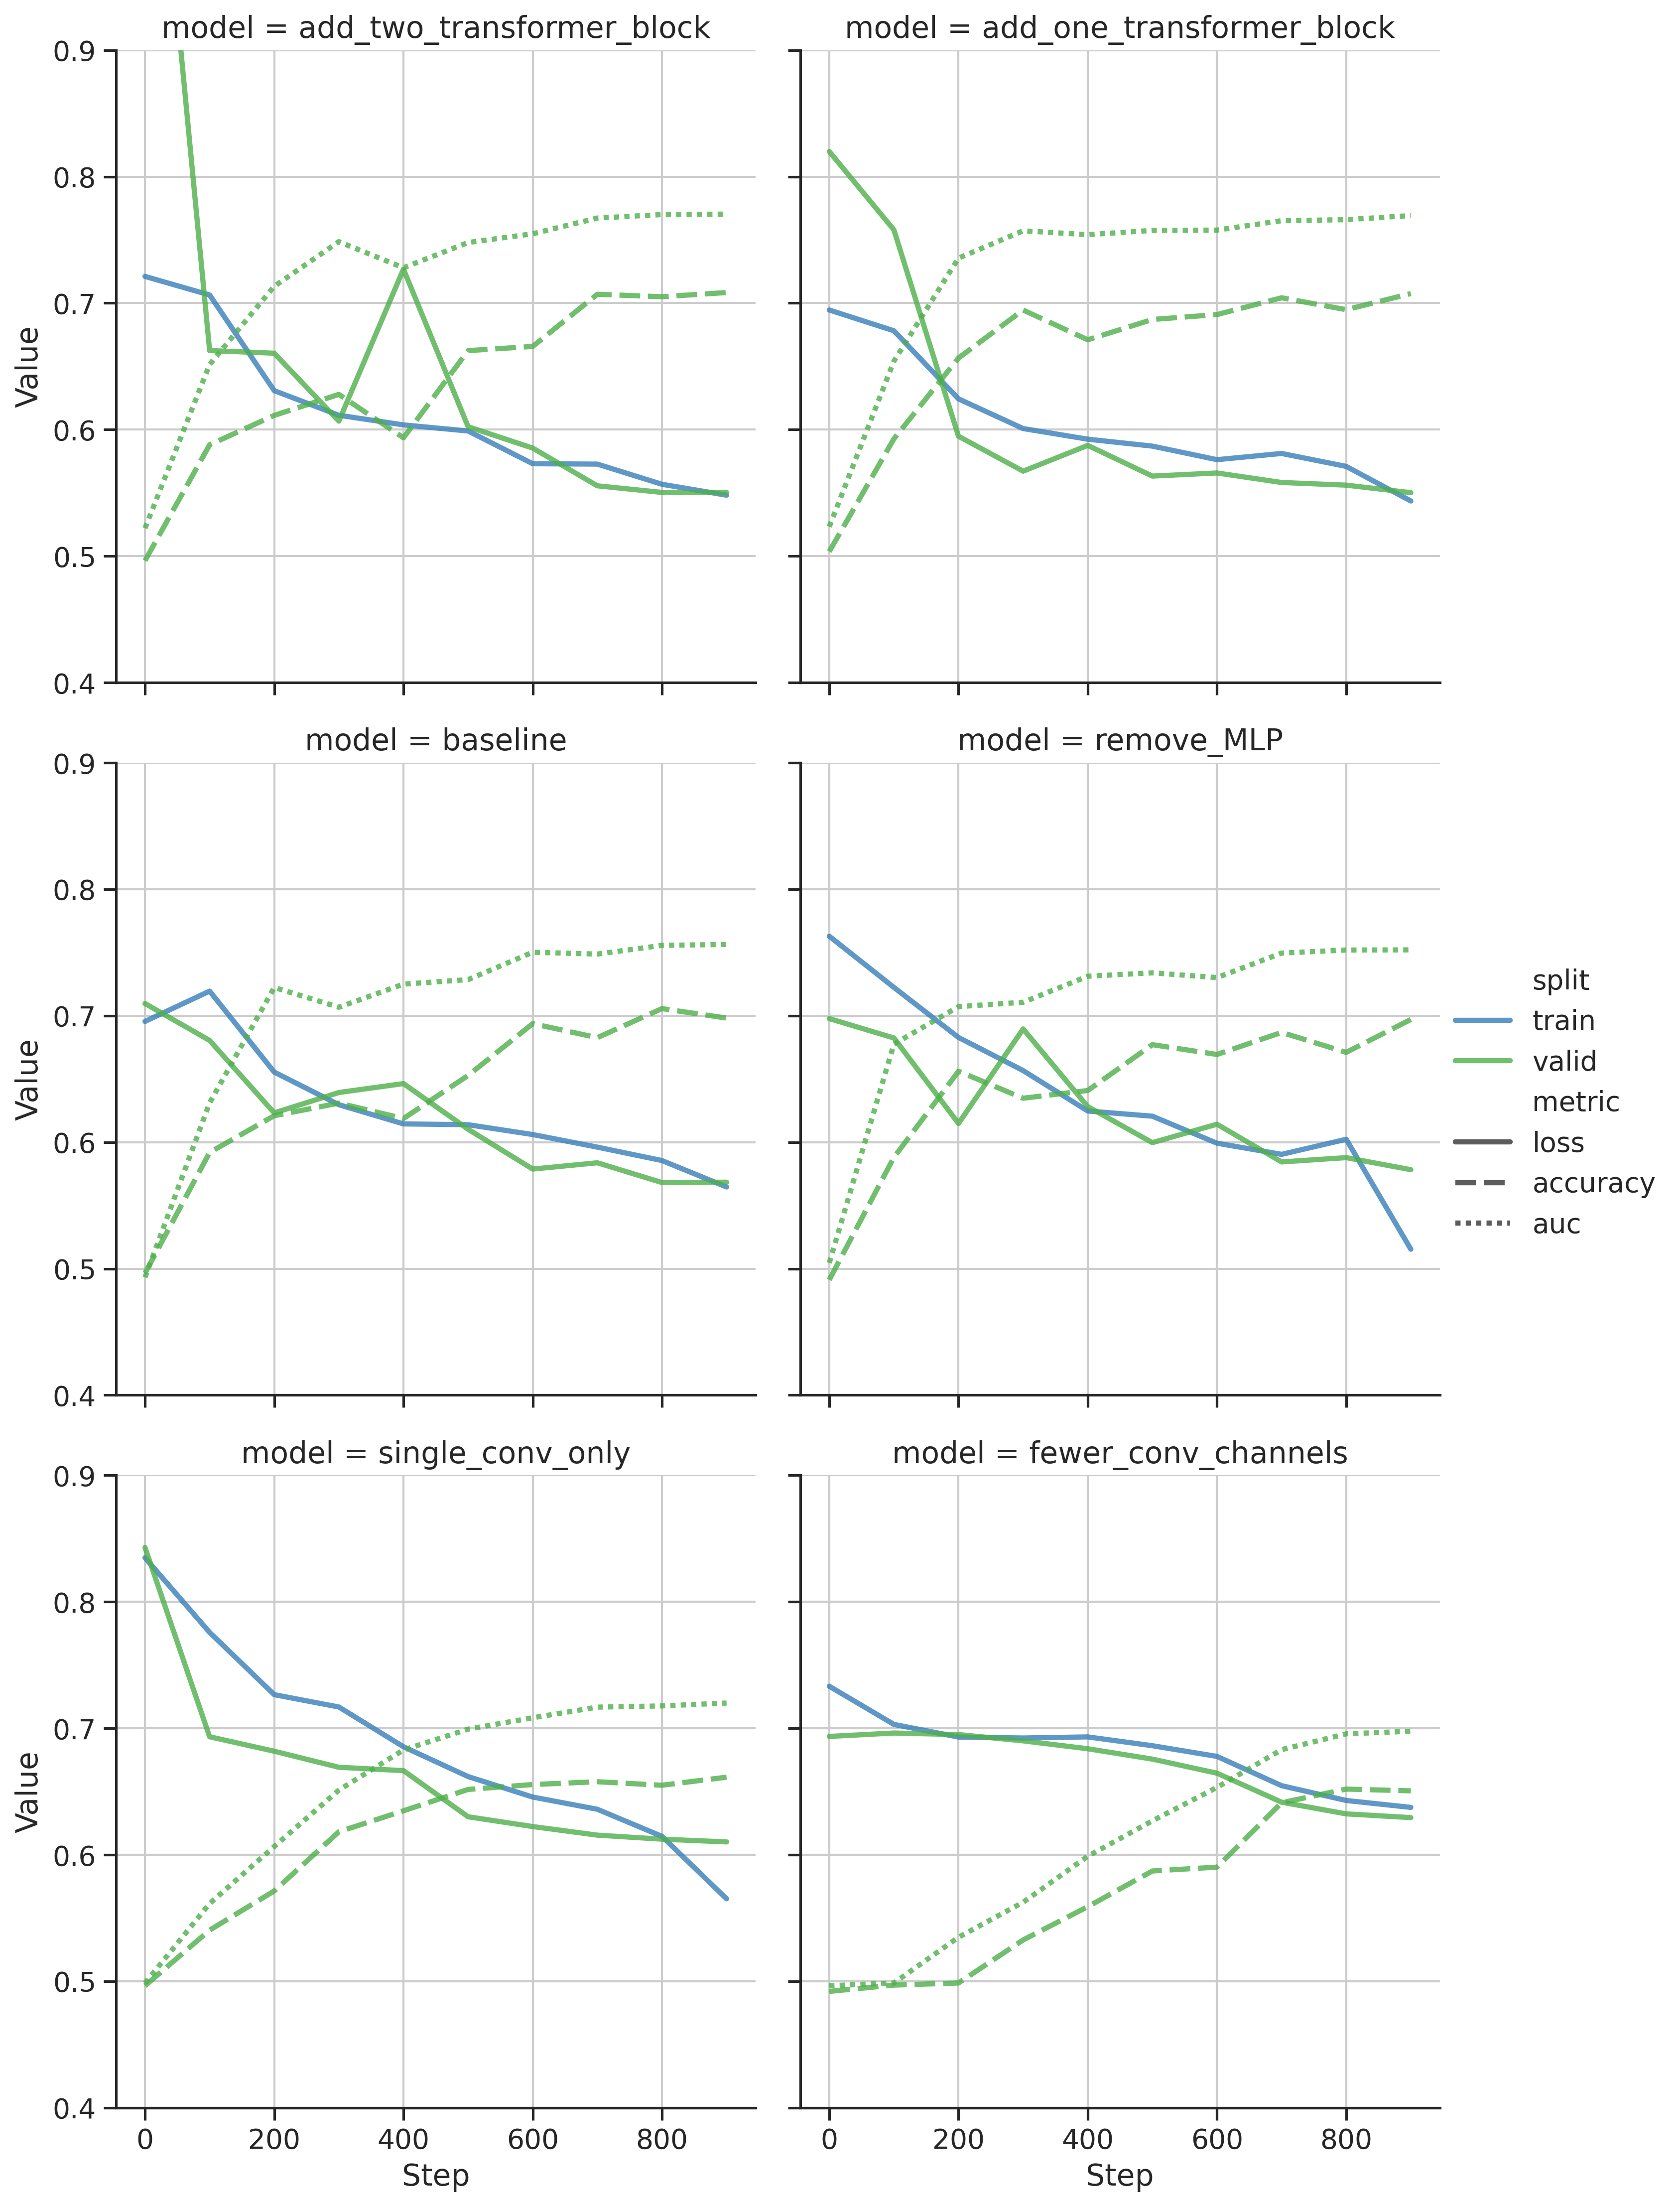

In [9]:
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.set_style("ticks", {"axes.grid": True})
g = sns.relplot(
  data=model_df,
  x="round",
  y="mean",
  hue="split",
  style="metric",
  kind="line",
  col="model",
  col_order=model_order,
  col_wrap=2,
  alpha=0.8,
  palette=DEFAULT_SPLIT_COLORS,
  dashes=True,
)
g.set_axis_labels("Step", "Value")
g.set(ylim=(0.4, 0.9));

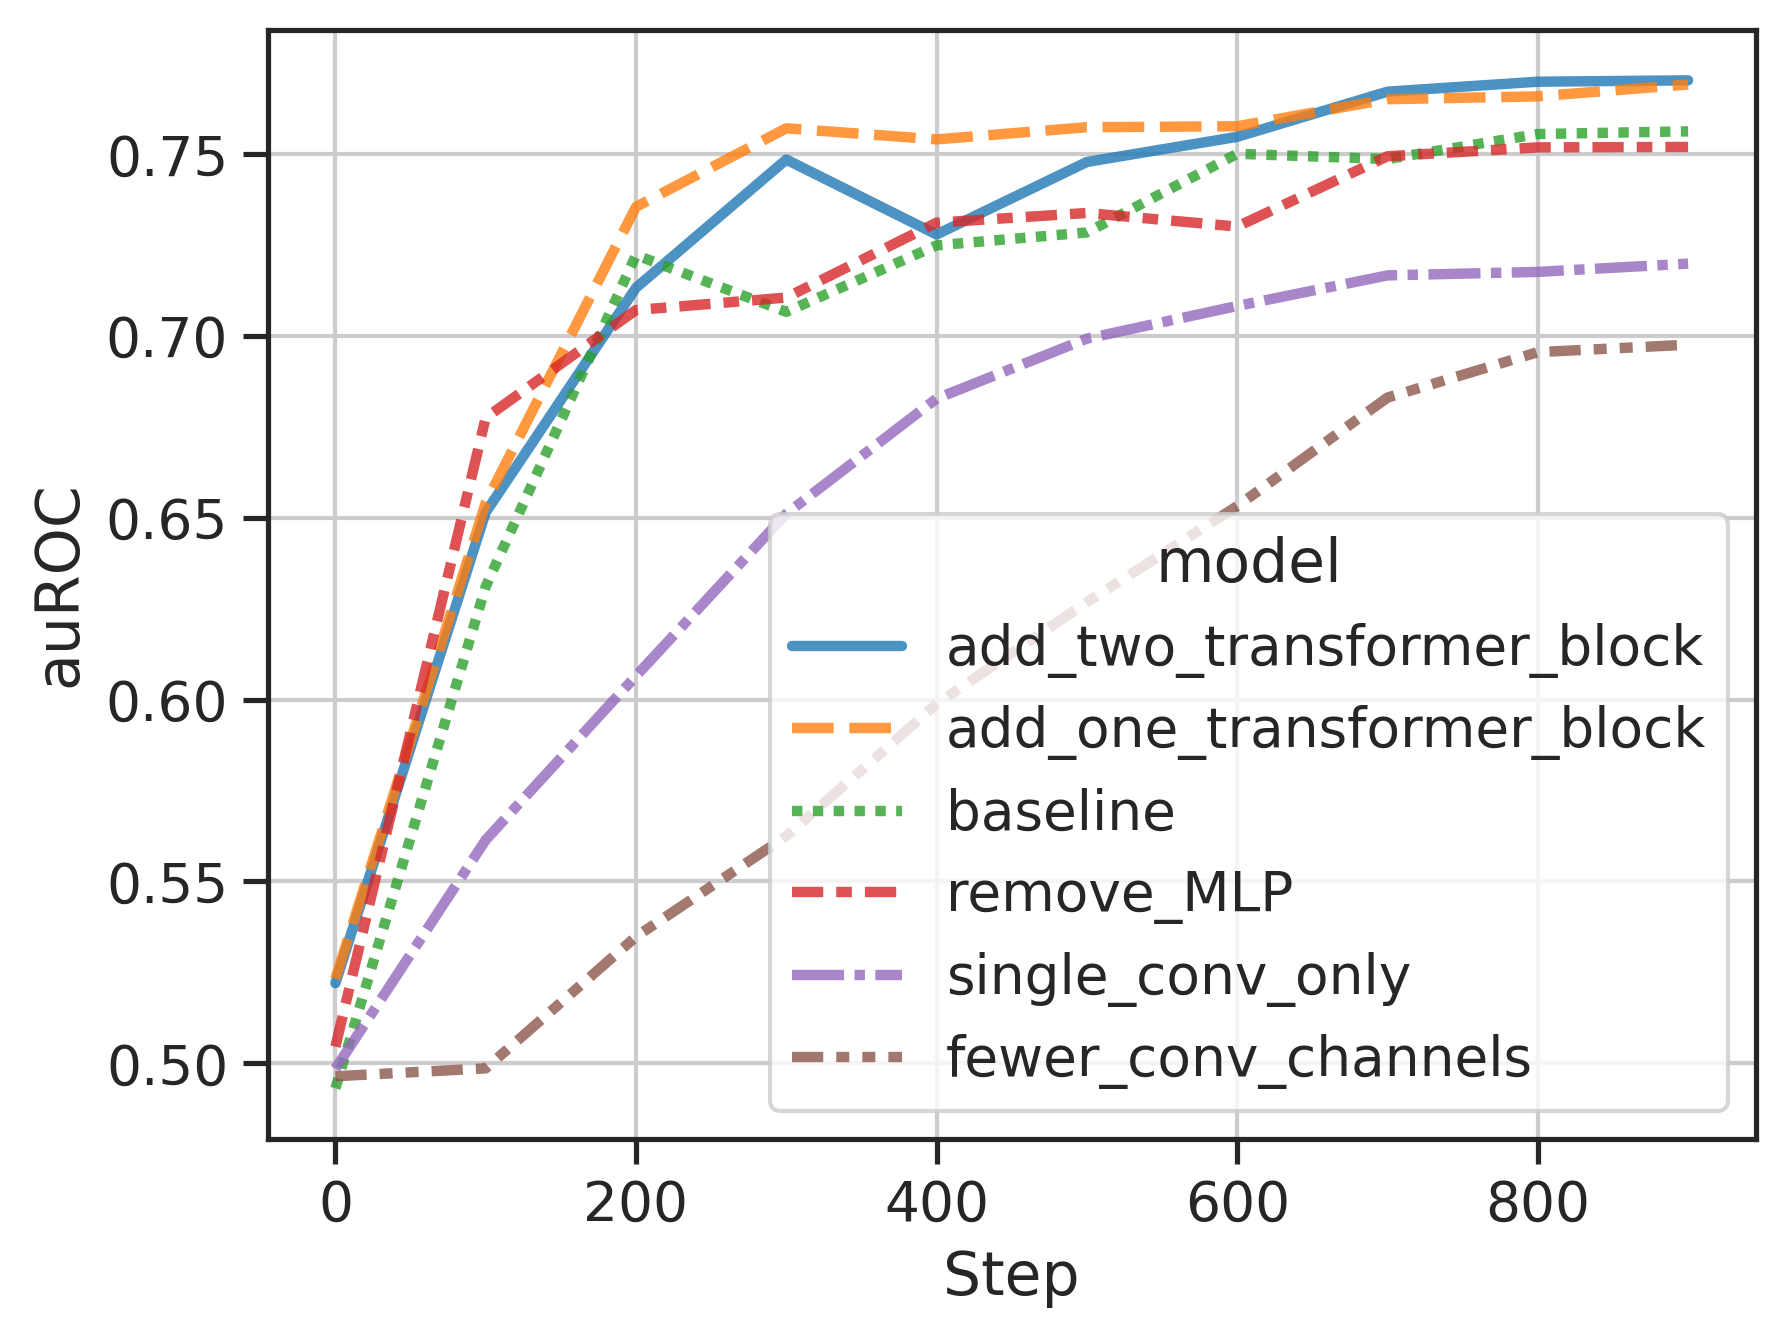

In [10]:
g = sns.lineplot(
  data=model_df[(model_df["metric"] == "auc")],
  x="round",
  y="mean",
  hue="model",
  style="model",
  alpha=0.8,
)
g.set_xlabel("Step")
g.set_ylabel("auROC");

In [11]:
print(max_auc_by_model.sort_values(ascending=False))

model
add_two_transformer_block    0.770343
add_one_transformer_block    0.769196
baseline                     0.756317
remove_MLP                   0.752024
single_conv_only             0.719931
fewer_conv_channels          0.697637
Name: mean, dtype: float64


### 3.5.4. Evaluating on the Test Split


In [ ]:
from dlfb.utils.restore import restore

# Identify best-performing model variant based on validation auROC.
top_model = model_order[0]

# Restore the trained model state from disk.
state, _ = restore(
  assets(f"dna/models/{top_model}"),
  models[top_model].create_train_state(
    rng=rng_init,
    dummy_input=next(dataset_splits["train"].as_numpy_iterator())["sequences"],
    tx=optax.adamw(
      optax.cosine_decay_schedule(
        init_value=learning_rate,
        decay_steps=num_steps,
      )
    ),
  ),
)

# Evaluate on the held-out test set.
test_batch = next(dataset_splits["test"].as_numpy_iterator())
metrics = eval_step(state, test_batch)
print(metrics)

{'loss': 0.5123618841171265, 'accuracy': 0.75, 'auc': 0.8196078431372549}


### 3.5.5. Extensions and Improvements


## 3.6. Summary
